## **Table of Contents**

1. [Data Preparation: ](#data_prep)
2. [Model Definition:](#model_def)
3. [Compilation and Training:](#comp_train)
4. [Evaluation and Testing](#eval_test)


In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Checking if using TPU or GPU
if tf.config.experimental.list_physical_devices('TPU'):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Using TPU")
elif tf.config.experimental.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    print("Using GPU")
else:
    strategy = tf.distribute.get_strategy()
    print("Using CPU")


Using GPU


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
from keras.models import load_model


______________________________________________________________________________________________________
# **Dataset:**
______________________________________________________________________________________________________

## **Loading and Preliminary Visualization**
______________________________________________________________________________________________________

In [ ]:

def load_data(file_path, file_type='txt', index_col=None):
    """
    Load data from a file.

    Input:
        file_path (str): The path to the file.
        file_type (str): Type of file. Options: 'txt' or 'csv' (default is 'txt').
        index_col (str, int, list of str or int, or False, default None):
            Column(s) to set as index for CSV files.
            Pass False to disable indexing.

    Returns:
        list, DataFrame or None: The loaded data.
    """
    if file_type == 'txt':
        with open(file_path, 'r') as file:
            data = [line.strip() for line in file]
    elif file_type == 'csv':
        if index_col is None:
            data = pd.read_csv(file_path)
        else:
            data = pd.read_csv(file_path, index_col=index_col)
    else:
        raise ValueError("Invalid file type. Use 'txt' or 'csv'.")

    return data

In [ ]:
main_data_path = "/content/drive/MyDrive/Colab Notebooks/research/main_data/"


In [ ]:


# Defining file paths for text files and csv
all_seeds_list_path = main_data_path + "all_seeds_list.txt"

property_profile_path = main_data_path + "property_profile.csv"

train_user_prop_interaction_path = main_data_path + "train_user_prop_interaction.csv"
train_user_profile_path = main_data_path + "train_user_profile.csv"

test_user_prop_interaction_path = main_data_path + "test_user_prop_interaction.csv"
test_user_profile_path = main_data_path + "test_user_profile.csv"


valid_user_prop_interaction_path = main_data_path + "eval_user_prop_interaction.csv"
valid_user_profile_path = main_data_path + "eval_user_profile.csv"

# Loading all_seed_words
all_seed_words = load_data(all_seeds_list_path)

# Loading CSV files with indexing saved from previous pipeline
property_profile_df = load_data(property_profile_path, file_type='csv', index_col='property_id')

train_user_profile_df = load_data(train_user_profile_path, file_type='csv', index_col='user_id')
train_user_prop_interaction_df = load_data(train_user_prop_interaction_path, file_type='csv', index_col=0)

valid_user_profile_df = load_data(valid_user_profile_path, file_type='csv', index_col='user_id')
valid_user_prop_interaction_df = load_data(valid_user_prop_interaction_path, file_type='csv', index_col=0)

test_user_profile_df = load_data(test_user_profile_path, file_type='csv', index_col='user_id')
test_user_prop_interaction_df = load_data(test_user_prop_interaction_path, file_type='csv', index_col=0)

**Property_Profile**

In [ ]:
property_profile_df

,bungalow,cottage,apartment,flat,balcony,abode,condo,townhouse,pet-friendly,smoke-free,...,host,cancellation,hospitality,communication,check-in,check-out,instruction,responsive,approachable,condition
property_id,,,,,,,,,,,,,,,,,,,,,
241032,0.0,0.0,0.264358,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
953595,0.0,0.0,0.815333,0.737533,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3308979,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7421966,0.0,0.0,0.685822,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
278830,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.149888,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101950,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.913615,0.0
8902327,0.0,0.0,0.322265,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
10267360,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
property_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3818 entries, 241032 to 10208623
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bungalow               3818 non-null   float64
 1   cottage                3818 non-null   float64
 2   apartment              3818 non-null   float64
 3   flat                   3818 non-null   float64
 4   balcony                3818 non-null   float64
 5   abode                  3818 non-null   float64
 6   condo                  3818 non-null   float64
 7   townhouse              3818 non-null   float64
 8   pet-friendly           3818 non-null   float64
 9   smoke-free             3818 non-null   float64
 10  bedroom                3818 non-null   float64
 11  amenities              3818 non-null   float64
 12  toilet                 3818 non-null   float64
 13  bathroom               3818 non-null   float64
 14  kitchen                3818 non-null   float64
 15  

**Training Data**

In [ ]:
train_user_prop_interaction_df

,241032,953595,3308979,7421966,278830,5956968,1909058,856550,4948745,2493658,...,1844791,6120046,262764,8578490,3383329,8101950,8902327,10267360,9604740,10208623
user_id,,,,,,,,,,,,,,,,,,,,,
9129697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10977089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27450730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10922774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31037410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7859809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_user_profile_df

,bungalow,cottage,apartment,flat,balcony,abode,condo,townhouse,pet-friendly,smoke-free,...,host,cancellation,hospitality,communication,check-in,check-out,instruction,responsive,approachable,condition
user_id,,,,,,,,,,,,,,,,,,,,,
9129697,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
10977089,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.406511,0.0,0.0
27450730,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
10922774,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
31037410,0.0,0.0,0.618467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084798,0.0,0.0,0.436867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
254465,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.546189,0.000000,0.0,0.0
7859809,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


**Validation Data**

In [ ]:
valid_user_prop_interaction_df

,241032,953595,3308979,7421966,278830,5956968,1909058,856550,4948745,2493658,...,1844791,6120046,262764,8578490,3383329,8101950,8902327,10267360,9604740,10208623
user_id,,,,,,,,,,,,,,,,,,,,,
19136870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8631871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17639945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3188802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39176653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20956757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23180352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
valid_user_profile_df

,bungalow,cottage,apartment,flat,balcony,abode,condo,townhouse,pet-friendly,smoke-free,...,host,cancellation,hospitality,communication,check-in,check-out,instruction,responsive,approachable,condition
user_id,,,,,,,,,,,,,,,,,,,,,
19136870,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8631871,0.0,0.0,0.723967,0.0,0.404612,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155626,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17639945,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.743667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3188802,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39176653,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20956757,0.0,0.0,0.000000,0.0,0.534007,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23180352,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Testing Data**

In [ ]:

test_user_prop_interaction_df

,241032,953595,3308979,7421966,278830,5956968,1909058,856550,4948745,2493658,...,1844791,6120046,262764,8578490,3383329,8101950,8902327,10267360,9604740,10208623
user_id,,,,,,,,,,,,,,,,,,,,,
27099102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5098623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1168337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5295478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5471216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
352959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28284877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_user_profile_df

,bungalow,cottage,apartment,flat,balcony,abode,condo,townhouse,pet-friendly,smoke-free,...,host,cancellation,hospitality,communication,check-in,check-out,instruction,responsive,approachable,condition
user_id,,,,,,,,,,,,,,,,,,,,,
27099102,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0
5098623,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0
1168337,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0
767996,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0
5295478,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5471216,0.0,0.0,0.0000,0.0,0.0,0.134742,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.8949,0.0,0.0,0.000000,0.0,0.0,0.0
352959,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0
28284877,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0


## **Further Anlaysis and Visualization:**
______________________________________________________________________________________________________

In [ ]:

def plot_zero_nonzero_proportions(df, num_columns=50, zero_color='green', nonzero_color='orange', grid_color='black',df_name= ''):
    """
    Plot the proportions of zero and non-zero entries in each column of a DataFrame as a bar graph.

    Input:
        df (DataFrame): The DataFrame containing the data.
        num_columns (int): The number of columns to include in the plot (default is 50).
        zero_color (str): The color for zero counts in the bar graph (default is 'green').
        nonzero_color (str): The color for non-zero counts in the bar graph (default is 'orange').
        grid_color (str): The color of the gridlines (default is 'black').

    Returns:
        None
    """
    # Selecting the first num_columns columns
    df_subset = df.iloc[:, :num_columns]

    # Calculate the count of zero and non-zero entries for each column
    zero_counts = (df_subset == 0).sum()
    nonzero_counts = (df_subset != 0).sum()

    # Determine the tick gap based on the total count divided by 40 and rounded to the nearest 10
    total_count = len(df)
    tick_gap = math.ceil(total_count / 40)
    tick_gap = math.ceil(tick_gap / 10) * 10

    fig, ax = plt.subplots(figsize=(10, 8))
    bar_width = 0.75
    index = range(num_columns)
    ax.barh(index, nonzero_counts, bar_width, color=nonzero_color, label='Non-Zero')
    ax.barh(index, zero_counts, bar_width, color=zero_color, label='Zero', left=nonzero_counts)

    ax.set_xlabel('Count')
    ax.set_ylabel('Topic Words')
    ax.set_title('Proportions of Zero and Non-zero Entries in Each Column of '+ df_name)

    ax.set_xticks(range(0, max(zero_counts + nonzero_counts) + 1, tick_gap))
    ax.set_yticks(index)

    # Rotate x-axis labels diagonally
    ax.set_xticklabels(range(0, max(zero_counts + nonzero_counts) + 1, tick_gap), rotation=45, ha='right')

    # Keep y-axis labels as default orientation
    ax.set_yticklabels(df_subset.columns)

    ax.xaxis.grid(True, color=grid_color)  # Show gridlines only on the x-axis and change color
    ax.yaxis.grid(False)  # Hide gridlines on the y-axis
    ax.legend()
    plt.show()



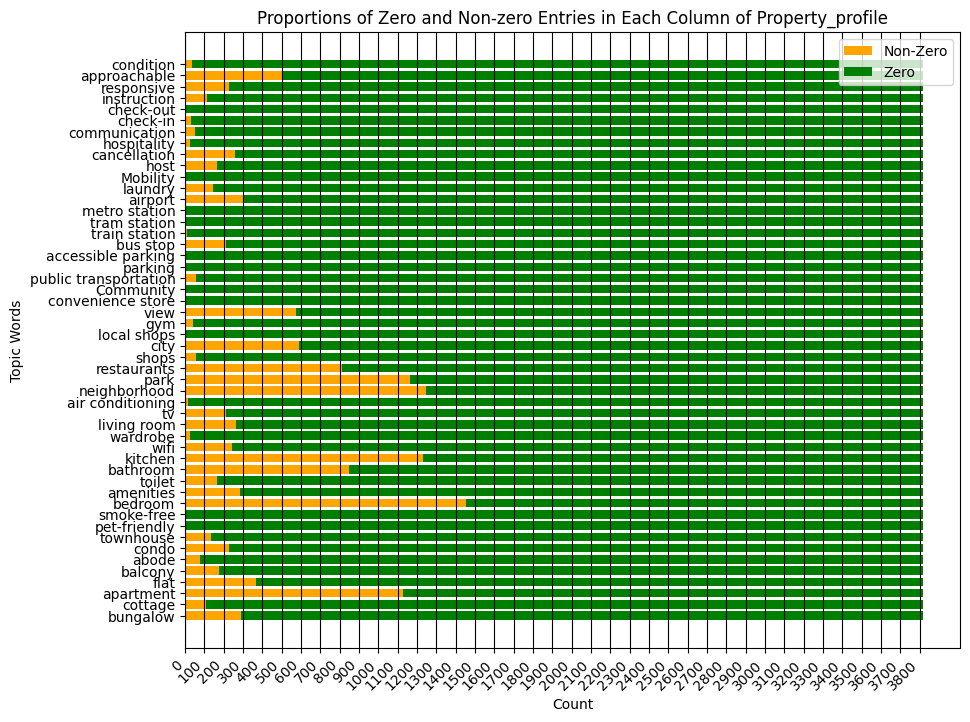

In [ ]:
plot_zero_nonzero_proportions(property_profile_df,df_name= 'Property_profile')


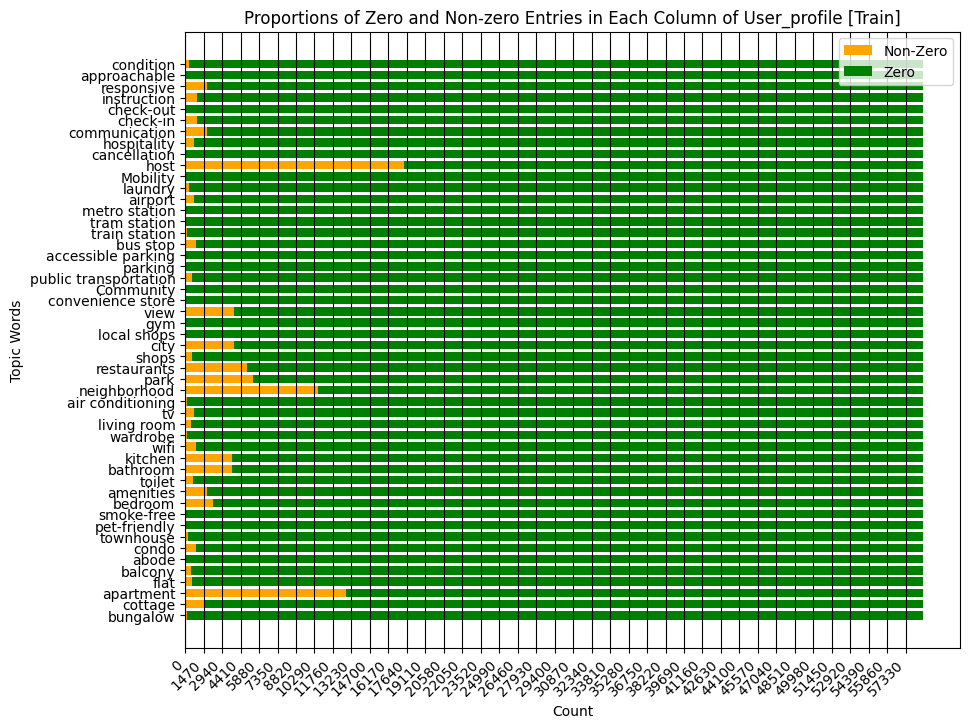

In [ ]:
plot_zero_nonzero_proportions(train_user_profile_df,df_name= 'User_profile [Train]')

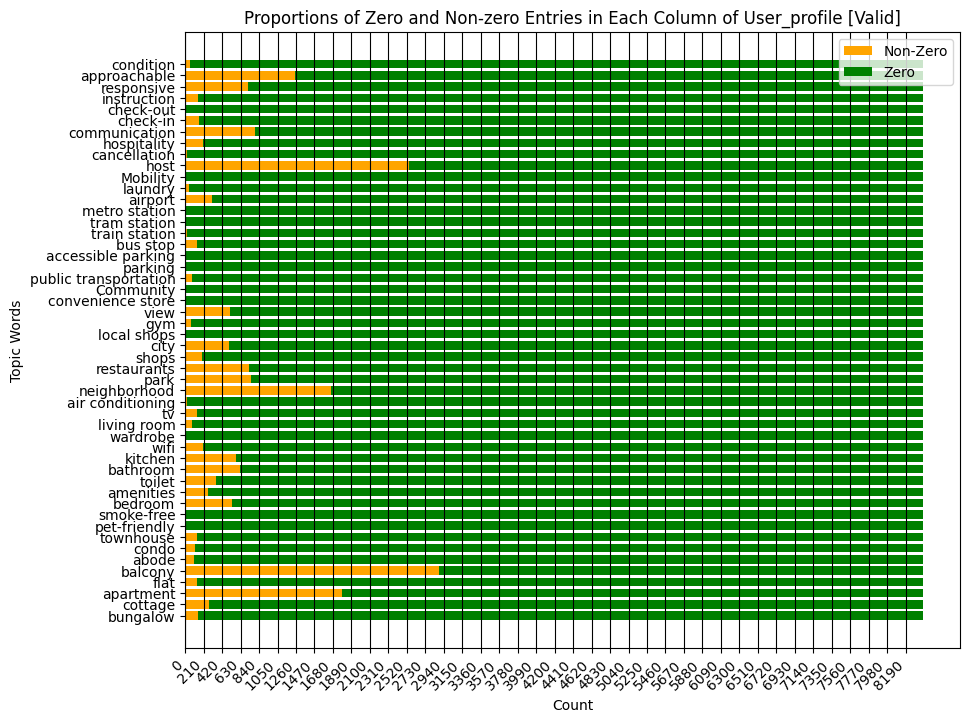

In [ ]:
plot_zero_nonzero_proportions(valid_user_profile_df,df_name= 'User_profile [Valid]')

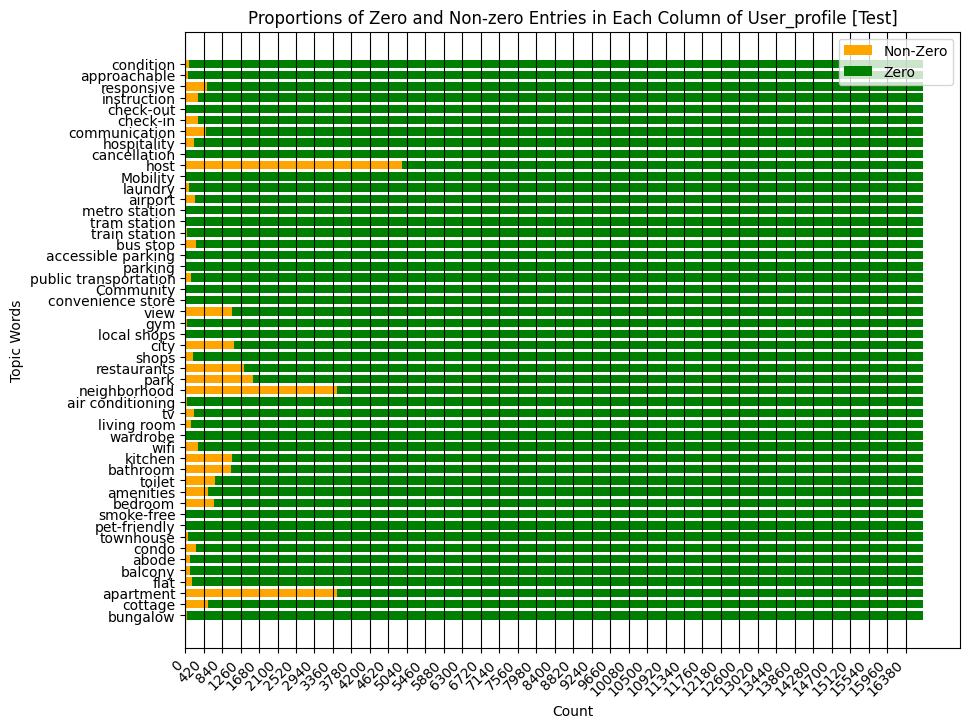

In [ ]:
plot_zero_nonzero_proportions(test_user_profile_df,df_name= 'User_profile [Test]')

In [ ]:

def calculate_sparsity(df):
    """
    Calculate the sparsity of a DataFrame.

    Input:
        df (pd.DataFrame): The DataFrame for which sparsity is to be calculated.

    Returns:
        float: The sparsity of the DataFrame.
    """
    total_elements = df.size
    non_zero_elements = df.astype(bool).sum().sum()  # Count non-zero elements
    sparsity = 1 - (non_zero_elements / total_elements)
    return sparsity

# Calculating sparsity for all data
sparsity_data = {
    'Data': ['train_user_property_interaction', 'valid_user_property_interaction', 'test_user_property_interaction',
                  'train_user_profile', 'valid_user_profile', 'test_user_profile', 'property_profile'],
    'Sparsity': [calculate_sparsity(train_user_prop_interaction_df),
                 calculate_sparsity(valid_user_prop_interaction_df),
                 calculate_sparsity(test_user_prop_interaction_df),
                 calculate_sparsity(train_user_profile_df),
                 calculate_sparsity(valid_user_profile_df),
                 calculate_sparsity(test_user_profile_df),
                 calculate_sparsity(property_profile_df)]
}

# DataFrame for sparsity data for tabular representation
sparsity_df = pd.DataFrame(sparsity_data)

sparsity_df


,Data,Sparsity
0,train_user_property_interaction,0.999738
1,valid_user_property_interaction,0.999738
2,test_user_property_interaction,0.999738
3,train_user_profile,0.970383
4,valid_user_profile,0.954181
5,test_user_profile,0.969329
6,property_profile,0.927428


In [ ]:

# grabbing unique user IDs in the training data
train_unique_user_ids = set(train_user_prop_interaction_df.index)

total_train_users = len(train_unique_user_ids)
total_test_users = len(test_user_prop_interaction_df)
total_valid_users = len(valid_user_prop_interaction_df)

# Checking for re-occurrences of train_unique_user_ids  in test and validation data
test_reoccurrences = test_user_prop_interaction_df[test_user_prop_interaction_df.index.isin(train_unique_user_ids)]
valid_reoccurrences = valid_user_prop_interaction_df[valid_user_prop_interaction_df.index.isin(train_unique_user_ids)]


# grabbing user IDs in test and validation data that are not present in the training data but have multiple occurrences
test_missing_users = list(set(test_user_prop_interaction_df.index) - train_unique_user_ids)
valid_missing_users = list(set(valid_user_prop_interaction_df.index) - train_unique_user_ids)

test_missing_multiple_occurrences = test_user_prop_interaction_df.loc[test_missing_users]
valid_missing_multiple_occurrences = valid_user_prop_interaction_df.loc[valid_missing_users]

# grabbing user_ids that are new in test and validation data
test_new_users = test_user_prop_interaction_df[~test_user_prop_interaction_df.index.isin(train_unique_user_ids)]
valid_new_users = valid_user_prop_interaction_df[~valid_user_prop_interaction_df.index.isin(train_unique_user_ids)]

# Excluding users with history in the test data
test_new_users_no_history = test_new_users[~test_new_users.index.isin(test_reoccurrences.index)]

# Finding occurrences of each remaining user in the test data
test_new_users_occurrences = test_new_users_no_history.index.value_counts()

# Filtering out users with only one occurrence in the test data
test_new_users_multiple_occurrences = test_new_users_occurrences[test_new_users_occurrences > 1]

# Counting the number of remaining users with multiple occurrences in the test data
num_new_users_multiple_occurrences = len(test_new_users_multiple_occurrences)

# Finding maximum and minimum occurrences of new users in the test data
max_occurrences = test_new_users_occurrences.max()
min_occurrences = test_new_users_occurrences.min()


# Excluding users with history in the validation data
valid_new_users_no_history = valid_new_users[~valid_new_users.index.isin(valid_reoccurrences.index)]

# Finding occurrences of each remaining user in the validation data
valid_new_users_occurrences = valid_new_users_no_history.index.value_counts()

# Filtering out users with only one occurrence in the validation data
valid_new_users_multiple_occurrences = valid_new_users_occurrences[valid_new_users_occurrences > 1]

# Counting the number of remaining users with multiple occurrences in the validation data
num_valid_new_users_multiple_occurrences = len(valid_new_users_multiple_occurrences)

# Finding maximum and minimum occurrences of new users in the validation data
max_valid_occurrences = valid_new_users_occurrences.max()
min_valid_occurrences = valid_new_users_occurrences.min()


In [ ]:

print("Dataset              | Total users | Users with history in training data | New users")
print("--------------------------------------------------------------------")
print("Training Data        | {:<11} |       --                            |  --".format(total_train_users))
print("Test Data            | {:<11} | {:<35} | {:<8}".format(total_test_users, len(test_reoccurrences), total_test_users - len(test_reoccurrences)))
print("Validation Data      | {:<11} | {:<35} | {:<8}".format(total_valid_users, len(valid_reoccurrences), total_valid_users - len(valid_reoccurrences)))
print("--------------------------------------------------------------------")
print()
print("New users with multiple occurrences (excluding users with history):")
print("--------------------------------------------------------------------")
print("Test Data        | {:<7} | Maximum: {:<4} | Minimum: {:<4}".format(num_new_users_multiple_occurrences, test_new_users_occurrences.max(), test_new_users_occurrences.min()))
print("Validation Data  | {:<7} | Maximum: {:<4} | Minimum: {:<4}".format(num_valid_new_users_multiple_occurrences, valid_new_users_occurrences.max(), valid_new_users_occurrences.min()))

print("--------------------------------------------------------------------")

Dataset              | Total users | Users with history in training data | New users
--------------------------------------------------------------------
Training Data        | 53817       |       --                            |  --
Test Data            | 16778       | 2445                                | 14333   
Validation Data      | 8390        | 1227                                | 7163    
--------------------------------------------------------------------

New users with multiple occurrences (excluding users with history):
--------------------------------------------------------------------
Test Data        | 186     | Maximum: 4    | Minimum: 1   
Validation Data  | 57      | Maximum: 3    | Minimum: 1   
--------------------------------------------------------------------


In [ ]:

def plot_long_tail_interactive(df, label=''):
    """
    Plot the long tail distribution of total occurrences of each property interactively using Plotly.

    Input:
    - df (pd.DataFrame): DataFrame with user_id as index and property_id as columns.
    - label (str): Label for the plot.
    """
    # Counting total occurrences of each property
    property_total_occurrences = df.sum()

    # Creating a DataFrame with property_id and corresponding total occurrences
    property_occurrences_df = pd.DataFrame(property_total_occurrences, columns=['Total Occurrences']).reset_index()
    property_occurrences_df.columns = ['Property ID', 'Total Occurrences']

    # Sorting the DataFrame by total occurrences
    sorted_df = property_occurrences_df.sort_values(by='Total Occurrences', ascending=False)

    # Ploting the distribution using Plotly
    fig = px.bar(sorted_df, x='Property ID', y='Total Occurrences', title=f'Long Tail Distribution of Total Occurrences of Properties ({label})')
    fig.update_xaxes(title='Property ID')
    fig.update_yaxes(title='Total Occurrences')

    fig.show()


# Concatenating all the train/test/valid user_prop_interaction_df along the rows
overall_user_prop_interaction_df = pd.concat([train_user_prop_interaction_df,
                                              test_user_prop_interaction_df,
                                              valid_user_prop_interaction_df])

# Ploting the long tail distribution for the overall dataset
plot_long_tail_interactive(overall_user_prop_interaction_df, 'Overall')


In [ ]:

# Ploting the long tail distribution for the individual dataset
plot_long_tail_interactive(train_user_prop_interaction_df, 'Train')
plot_long_tail_interactive(valid_user_prop_interaction_df, 'Validation')
plot_long_tail_interactive(test_user_prop_interaction_df, 'Test')


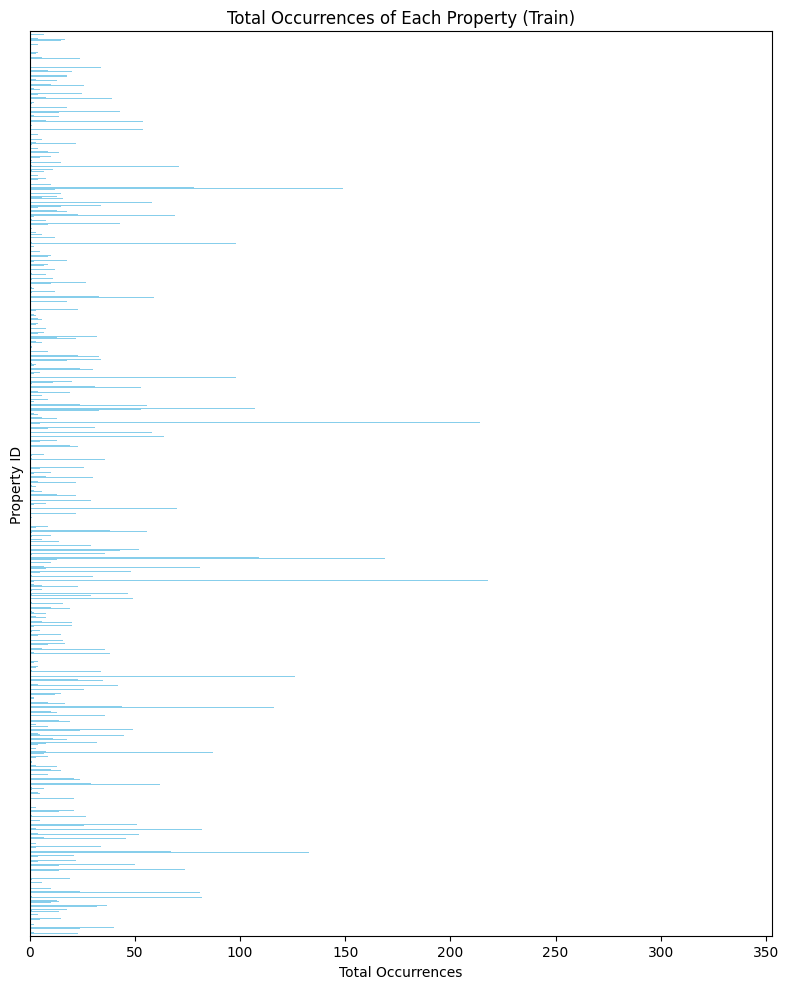

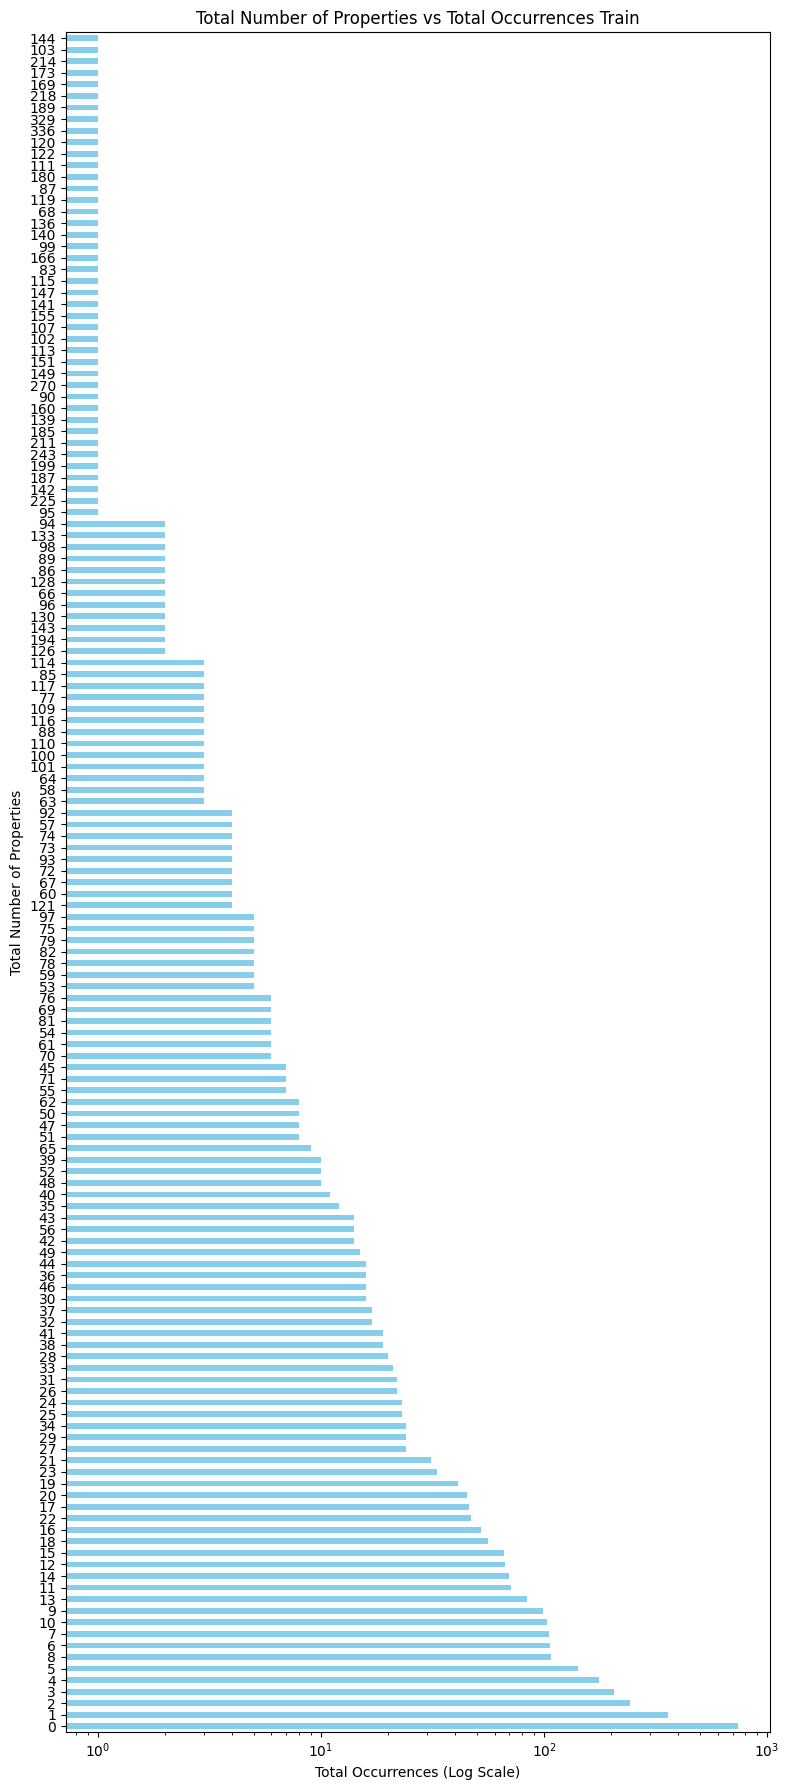

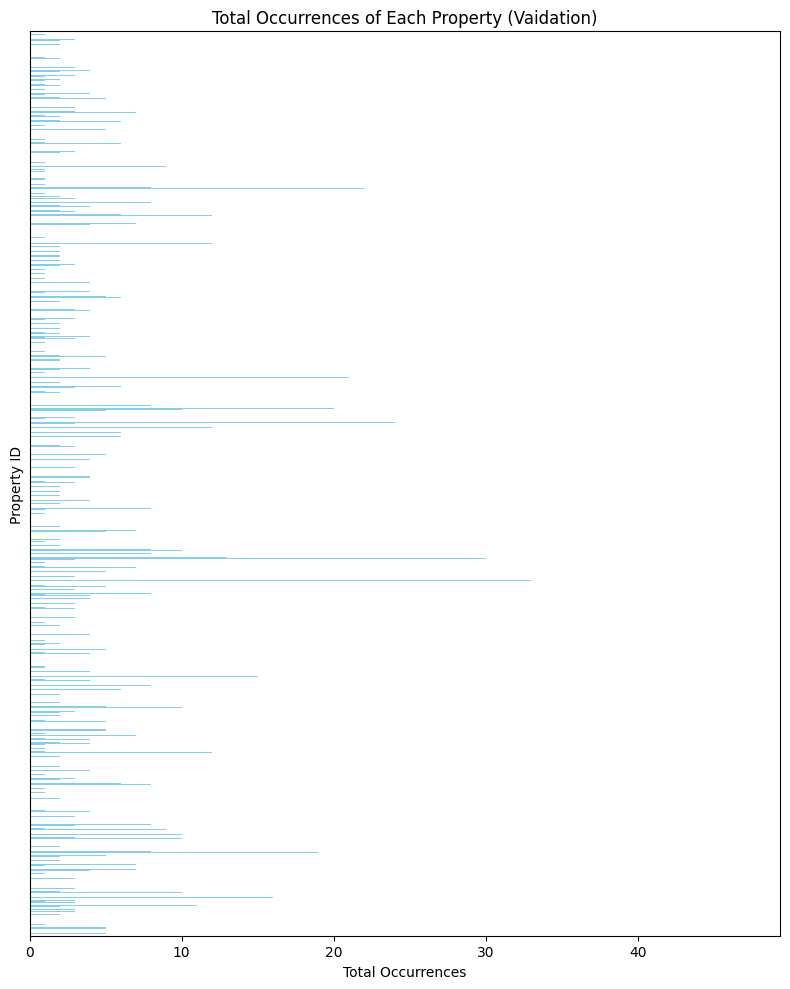

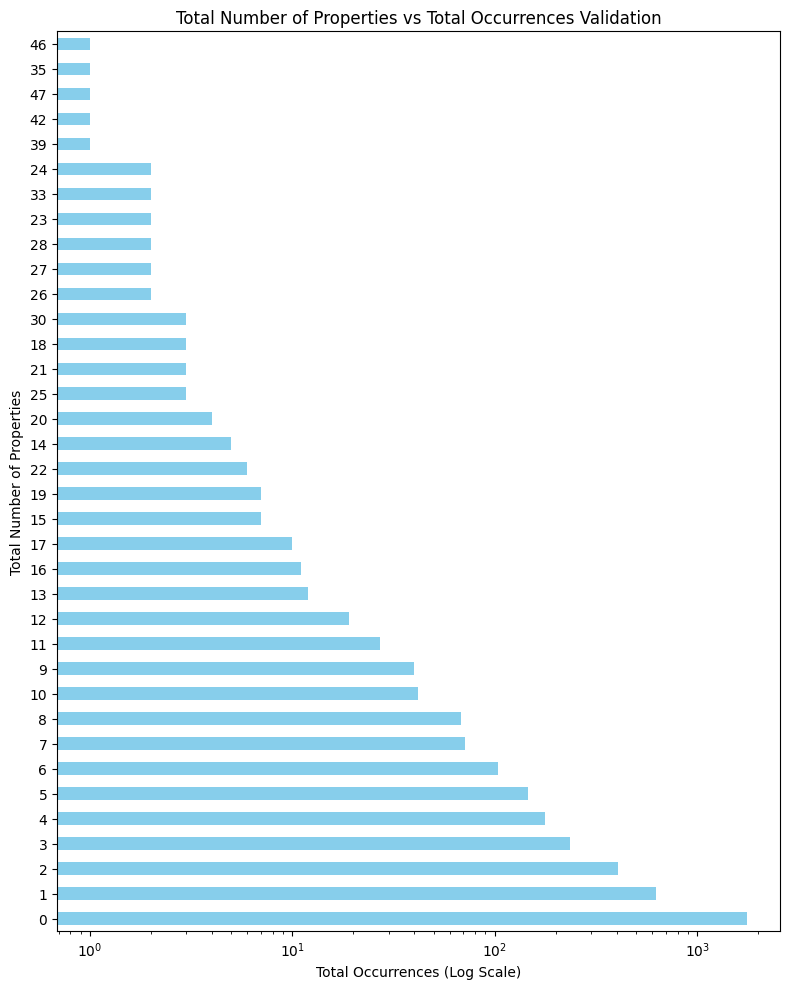

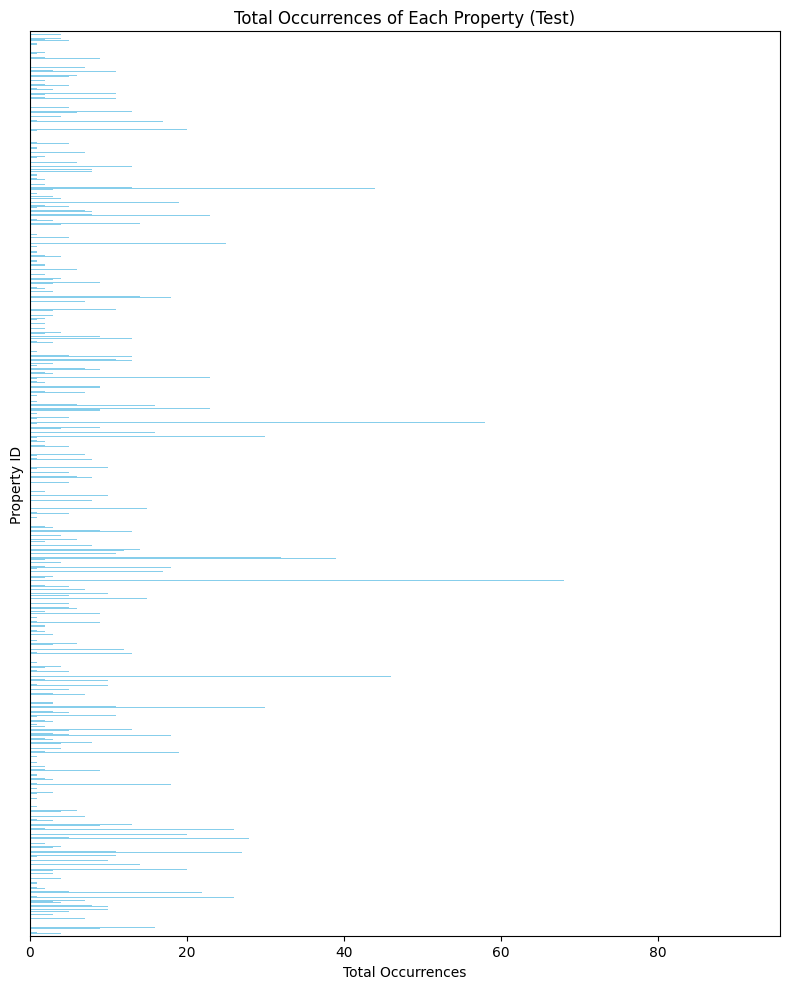

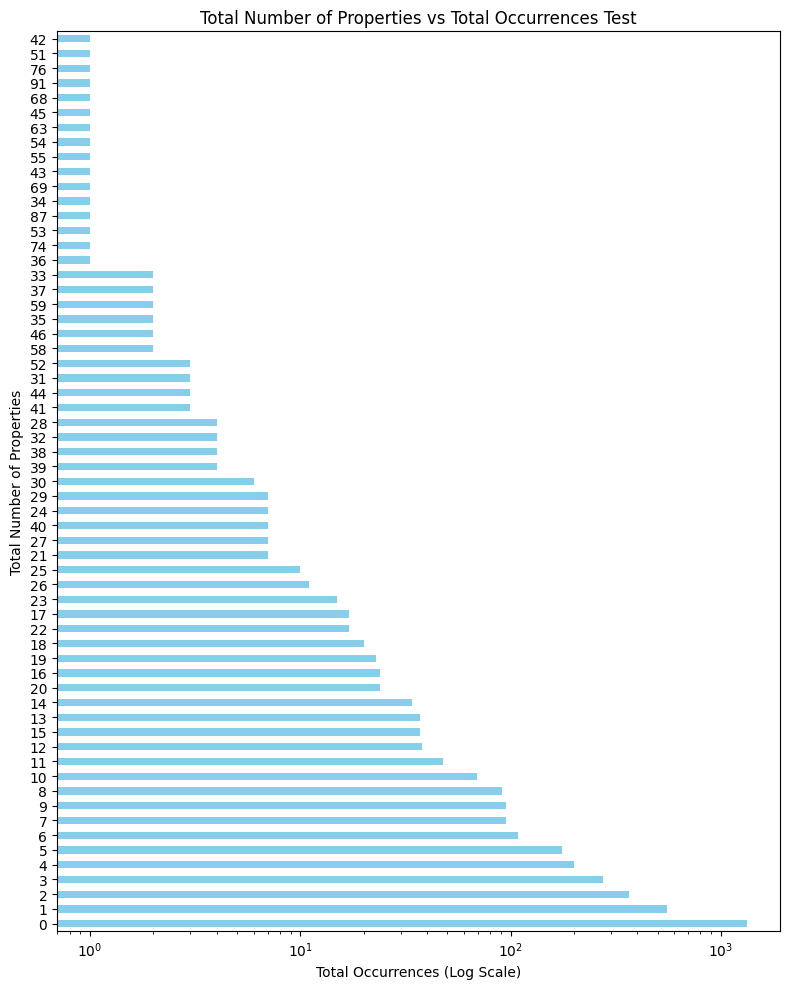

In [ ]:

def plot_total_occurrences_1(df,label=''):
    """
    Plot the total occurrences of each property for train, test, and eval datasets.

    Input:
    - train_df (pd.DataFrame): DataFrame containing train data with user_id as index and property_id as columns.
    - test_df (pd.DataFrame): DataFrame containing test data with user_id as index and property_id as columns.
    - eval_df (pd.DataFrame): DataFrame containing eval data with user_id as index and property_id as columns.
    """

    plt.figure(figsize=(8, 10))
    property_total_occurrences = df.sum()
    property_total_occurrences.plot(kind='barh', color='skyblue')
    plt.ylabel('Property ID')
    plt.xlabel('Total Occurrences')
    plt.title(f'Total Occurrences of Each Property ({label})')
    plt.yticks([])  # Removing ticks for property IDs

    plt.tight_layout()
    plt.show()

# =================================================================================================================================
# =================================================================================================================================

def plot_total_occurrences_2(df,label='',y_size=10):
    """
    Plot the total occurrences of each property.

    Input:
    - df (pd.DataFrame): DataFrame with user_id as index and property_id as columns.
    """
    # Counting total occurrences of each property
    property_total_occurrences = df.sum()

    # Counting unique total occurrences of property
    unique_total_occurrences = property_total_occurrences.value_counts()

    plt.figure(figsize=(8, y_size))
    unique_total_occurrences.plot(kind='barh', color='skyblue')
    plt.xlabel('Total Occurrences (Log Scale)')
    plt.ylabel('Total Number of Properties')
    plt.title(f'Total Number of Properties vs Total Occurrences {label}')
    plt.yticks(rotation=0)
    plt.xscale('log')  # Setting logarithmic scale for x-axis
    plt.tight_layout()
    plt.show()

# Ploting the total occurrences of each property for train, test, and eval datasets
plot_total_occurrences_1(train_user_prop_interaction_df,'Train')
plot_total_occurrences_2(train_user_prop_interaction_df,'Train',y_size=18)

plot_total_occurrences_1(valid_user_prop_interaction_df,'Vaidation')
plot_total_occurrences_2(valid_user_prop_interaction_df,'Validation')

plot_total_occurrences_1(test_user_prop_interaction_df,'Test')
plot_total_occurrences_2(test_user_prop_interaction_df,'Test')


______________________________________________________________________________________________________
# **SVD based Recommendor**
______________________________________________________________________________________________________

In [ ]:


class SVDRecommender:
    """
    SVDRecommender is a collaborative filtering recommendation system based on Singular Value Decomposition (SVD).

    Input:
            k (int): Number of latent features to  initialize the SVDRecommender object.
                    (Default is 50)

    Methods:

        _map_ids(user_id, item_id):
            Map user and item IDs to row and column indices.

        fit(interactions):
            Fit the model to the user-item interactions.

        predict(user_id, item_id):
            Predict the rating for a given user and item.

        recommend(user_id, item_popularity, top_n=5):
            Recommend top N items for a given user.
    """

    def __init__(self, k=50):
        self.k = k  # Number of latent features
        self.user_mapping = {}  # Mapping of user IDs to row indices
        self.item_mapping = {}  # Mapping of item IDs to column indices

    def _map_ids(self, user_id, item_id):
        """
        Map user and item IDs to row and column indices.

        Input:
            user_id (int or str): User ID.
            item_id (int or str): Item ID.

        """
        if user_id not in self.user_mapping:
            self.user_mapping[user_id] = len(self.user_mapping)
        if item_id not in self.item_mapping:
            self.item_mapping[item_id] = len(self.item_mapping)

    def fit(self, interactions):
        """
        Fit the model to the user-item interactions.

        Input:
            interactions (dict): A dictionary where keys are user IDs and values are dictionaries of item IDs and their corresponding ratings.
        """
        for user_id, user_data in interactions.items():
            for item_id in user_data.keys():
                self._map_ids(user_id, item_id)

        # Creating a user-item interaction matrix
        num_users = len(self.user_mapping)
        num_items = len(self.item_mapping)
        self.interactions_matrix = np.zeros((num_users, num_items))

        # Populating the interaction matrix
        for user_id, user_data in interactions.items():
            user_index = self.user_mapping[user_id]
            for item_id, interaction in user_data.items():
                item_index = self.item_mapping[item_id]
                self.interactions_matrix[user_index, item_index] = interaction

        # Performing SVD to decompose the interaction matrix
        U, Sigma, VT = np.linalg.svd(self.interactions_matrix, full_matrices=False)

        # Keeping only the top k singular values and corresponding vectors
        self.U = U[:, :self.k]
        self.Sigma = np.diag(Sigma[:self.k])
        self.VT = VT[:self.k, :]

    def predict(self, user_id, item_id):
        """
        Predict the rating for a given user and item.

        Input:
            user_id (int or str): User ID.
            item_id (int or str): Item ID.

        Returns:
            float: Predicted rating for the specified user and item.
        """
        self._map_ids(user_id, item_id)
        user_index = self.user_mapping[user_id]
        item_index = self.item_mapping[item_id]

        # Predict rating for the specified user and item
        user_factors = self.U[user_index, :]
        item_factors = np.dot(self.Sigma, self.VT)
        predicted_rating = np.dot(user_factors, item_factors[:, item_index])
        return predicted_rating

    def recommend(self, user_id, item_popularity, top_n=5):
        """
        Recommend top N items for a given user.

        Input:
            user_id (int or str): User ID.
            item_popularity (dict): A dictionary where keys are item IDs and values are their popularity scores.
            top_n (int): Number of items to recommend. Default is 5.

        Returns:
            list: List of top N recommended item IDs along with their scores as tuples.
        """
        user_index = self.user_mapping.get(user_id)

        if user_index is None:
            # New user: recommend based on item popularity
            recommended_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)[:top_n]
            return [(item_id, score) for item_id, score in recommended_items]

        # obtaining predicted ratings for the user
        predicted_ratings = np.dot(self.U[user_index, :], np.dot(self.Sigma, self.VT))

        # Filtering out items the user has already interacted with
        interacted_items = set(np.where(self.interactions_matrix[user_index, :] > 0)[0])

        # Combining predicted ratings with item popularity
        combined_scores = predicted_ratings + np.array([item_popularity.get(item_id, 0) for item_id in range(len(predicted_ratings))])

        # Sorting items by combined scores and recommend the top n items the user hasn't interacted with
        recommended_items = sorted(enumerate(combined_scores), key=lambda x: x[1], reverse=True)
        recommended_items = [(item_id, score) for item_id, score in recommended_items if item_id not in interacted_items][:top_n]

        return recommended_items



## **Data Preparation for Training SVD:** <a name="data_prep"></a>
______________________________________________________________________________________________________

In [ ]:

def preprocess_interaction_df(interaction_df):
    """
    Preprocess the interaction DataFrame into a dictionary format suitable for input to the SVDRecommender.

    Input:
        interaction_df (DataFrame): DataFrame containing user-item interactions where rows represent users, columns represent items,
                                    and cell values represent the interaction strength/rating.

    Returns:
        dict: A dictionary where keys are user IDs and values are dictionaries of item IDs and their corresponding ratings.
    """
    interactions = {}
    for user_id, user_data in interaction_df.iterrows():
        if user_id not in interactions:
            interactions[user_id] = {}
        for item_id, interaction in user_data.items():
            interactions[user_id][item_id] = interaction
    return interactions




In [ ]:
def scale_series(series):
    """
    Scale the values of a pandas Series to the range of 0 to 1.

    Input:
        series (pandas.Series): The input Series to be scaled.

    Returns:
        pandas.Series: The scaled Series with values in the range of 0 to 1.
    """
    # grabbing the maximum and minimum values
    max_value = series.max()
    min_value = series.min()

    # Scaling the values to the range of [0, 1]
    scaled_series = (series - min_value) / (max_value - min_value)

    return scaled_series

# computing item popularity
item_popularity = train_user_prop_interaction_df.sum()
# Scaling the item_popularity Series
scaled_item_popularity = scale_series(item_popularity)
scaled_item_popularity


241032      0.437500
953595      0.086310
3308979     0.053571
7421966     0.000000
278830      0.083333
              ...   
8101950     0.002976
8902327     0.005952
10267360    0.000000
9604740     0.000000
10208623    0.000000
Length: 3818, dtype: float64

In [ ]:

# Preprocessing the interaction DataFrame to make it compatible for svd
interactions_train = preprocess_interaction_df(train_user_prop_interaction_df)



**Item popularity measures how often each item is interacted with in the dataset. It is useful for suggesting popular items to new users who don't have much interaction history, helping them get started with relevant recommendations.**

## **Training & Evaluating SVD:** <a name="data_prep"></a>
______________________________________________________________________________________________________

In [ ]:
# Initilaizing the SVD recommender with latent features of k = 150
recommender = SVDRecommender(k=150)

# Fiting the model to the interaction data
recommender.fit(interactions_train)



In [ ]:
class SVD_Evaluator:
    """
    Evaluator class provides methods for evaluating recommendation models.

    Methods:
        evaluate_svd(recommender, interactions, item_popularity, top_k=5):
            Evaluate the performance of an SVD-based recommender system.

        calculate_precision(recommendations, ground_truth):
            Calculate the precision metric.

        calculate_recall(recommendations, ground_truth):
            Calculate the recall metric.

        calculate_f1_score(precision, recall):
            Calculate the F1-score metric.

        calculate_mrr(recommendations, ground_truth):
            Calculate the mean reciprocal rank (MRR) metric.

        calculate_topk_accuracy(recommendations, ground_truth, top_k):
            Calculate the top-K accuracy metric.
    """
    def evaluate_svd(self,recommender, interactions, item_popularity, top_k=5):
        """
            Evaluate the performance of an SVD-based recommender system.

            Input:
                recommender (SVDRecommender): The trained SVDRecommender object.
                interactions (dict): A dictionary where keys are user IDs and values are dictionaries of item IDs and their corresponding ratings.
                item_popularity (dict): A dictionary where keys are item IDs and values are their popularity scores.
                top_k (int): Number of items to recommend. Default is 5.

            Returns:
                tuple: A tuple containing average precision, recall, F1-score, MRR, and top-K accuracy.
        """
        precision_sum = 0
        recall_sum = 0
        f1_sum = 0
        mrr_sum = 0
        topk_accuracy_sum = 0
        num_evaluated_users = 0

        for user_id, user_data in interactions.items():
            # Generating recommendations for the user
            recommendation_score = recommender.recommend(user_id, item_popularity, top_n=top_k)
            # print(recommendation_score)

            recommendations = [item_id for item_id, _ in recommendation_score]

            # Extracting ground truth interactions
            ground_truth = {item_id: interaction for item_id, interaction in user_data.items() if interaction > 0}

            # Calculating evaluation metrics
            precision = self.calculate_precision_svd(recommendations, ground_truth)
            recall = self.calculate_recall_svd(recommendations, ground_truth)
            f1_score = self.calculate_f1_score_svd(precision, recall)
            mrr = self.calculate_mrr_svd(recommendations, ground_truth)
            topk_accuracy = self.calculate_topk_accuracy_svd(recommendations, ground_truth, top_k)

            # Updating sum of metrics
            precision_sum += precision
            recall_sum += recall
            f1_sum += f1_score
            mrr_sum += mrr
            topk_accuracy_sum += topk_accuracy
            num_evaluated_users += 1

        # Calculating average metrics
        avg_precision = precision_sum / num_evaluated_users
        avg_recall = recall_sum / num_evaluated_users
        avg_f1_score = f1_sum / num_evaluated_users
        avg_mrr = mrr_sum / num_evaluated_users
        avg_topk_accuracy = topk_accuracy_sum / num_evaluated_users

        return avg_precision, avg_recall, avg_f1_score, avg_mrr, avg_topk_accuracy

    def calculate_precision_svd(self,recommendations, ground_truth):
        """
            Calculate the precision metric.

            Input:
                recommendations (list): List of recommended item IDs.
                ground_truth (dict): Ground truth interactions where keys are item IDs and values are ratings.

            Returns:
                float: Precision score.
        """
        if len(recommendations) == 0:
            return 0
        else:
            num_correct_recommendations = sum(1 for item_id in recommendations if item_id in ground_truth)
            return num_correct_recommendations / len(recommendations)

    def calculate_recall_svd(self,recommendations, ground_truth):
        """
        Calculate the recall metric.

        Input:
            recommendations (list): List of recommended item IDs.
            ground_truth (dict): Ground truth interactions where keys are item IDs and values are ratings.

        Returns:
            float: Recall score.
        """
        if len(ground_truth) == 0:
            return 0
        else:
            num_correct_recommendations = sum(1 for item_id in recommendations if item_id in ground_truth)
            return num_correct_recommendations / len(ground_truth)

    def calculate_f1_score_svd(self,precision, recall):
        """
            Calculate the F1-score metric.

            Input:
                precision (float): Precision score.
                recall (float): Recall score.

            Returns:
                float: F1-score.
        """
        if precision == 0 and recall == 0:
            return 0
        else:
            return 2 * (precision * recall) / (precision + recall)

    def calculate_mrr_svd(self,recommendations, ground_truth):
        """
            Calculate the mean reciprocal rank (MRR) metric.

            Input:
                recommendations (list): List of recommended item IDs.
                ground_truth (dict): Ground truth interactions where keys are item IDs and values are ratings.

            Returns:
                float: MRR score.
        """
        for rank, item_id in enumerate(recommendations, 1):
            if item_id in ground_truth:
                return 1 / rank
        return 0

    def calculate_topk_accuracy_svd(self,recommendations, ground_truth, top_k):
        """
            Calculate the top-K accuracy metric.

            Input:
                recommendations (list): List of recommended item IDs.
                ground_truth (dict): Ground truth interactions where keys are item IDs and values are ratings.
                top_k (int): Number of items to consider for accuracy calculation.

            Returns:
                float: Top-K accuracy.
        """
        top_k_recommendations = recommendations[:top_k]
        num_correct = sum(1 for item_id in top_k_recommendations if item_id in ground_truth)
        return num_correct / min(len(ground_truth), top_k)


In [ ]:
recommendations = recommender.recommend(10001,scaled_item_popularity, top_n=10)
recommendations

[('365550', 1.0),
 ('208356', 0.9791666666666666),
 ('25002', 0.8035714285714286),
 ('47196', 0.7232142857142857),
 ('63308', 0.6696428571428571),
 ('92835', 0.6488095238095238),
 ('5682', 0.6369047619047619),
 ('279063', 0.6279761904761905),
 ('841049', 0.5922619047619048),
 ('258571', 0.5773809523809523)]

In [ ]:
# Instantiate the SVD_Evaluator class
evaluator = SVD_Evaluator()

# number of recommendations to get
top_k = 10

# Preprocessing the interaction validation data for svd
interactions_valid = preprocess_interaction_df(valid_user_prop_interaction_df)

# Evaluating recommendations on validation data
avg_precision_valid, avg_recall_valid, avg_f1_score_valid, avg_mrr_valid, avg_topk_accuracy_valid = evaluator.evaluate_svd(recommender, interactions_valid, scaled_item_popularity, top_k)

print("Validation Metrics:")
print("Average Precision:", avg_precision_valid)
print("Average Recall:", avg_recall_valid)
print("Average F1-Score:", avg_f1_score_valid)
print("Average MRR:", avg_mrr_valid)
print("Average Top-K Accuracy:", avg_topk_accuracy_valid)


Validation Metrics:
Average Precision: 0.0034052350945225555
Average Recall: 0.0340523509452254
Average F1-Score: 0.006191336535495518
Average MRR: 0.012101780039855663
Average Top-K Accuracy: 0.0340523509452254


In [ ]:
# Preprocessing the interaction test data for svd
interactions_test = preprocess_interaction_df(test_user_prop_interaction_df)

# Evaluating recommendations on test data
avg_precision_test, avg_recall_test, avg_f1_score_test, avg_mrr_test, avg_topk_accuracy_test = evaluator.evaluate_svd(recommender, interactions_test, scaled_item_popularity, top_k)

print("Testing Metrics:")
print("Average Precision:", avg_precision_test)
print("Average Recall:", avg_recall_test)
print("Average F1-Score:", avg_f1_score_test)
print("Average MRR:", avg_mrr_test)
print("Average Top-K Accuracy:", avg_topk_accuracy_test)



Testing Metrics:
Average Precision: 0.003463735183934197
Average Recall: 0.03463735183934164
Average F1-Score: 0.006297700334425808
Average MRR: 0.011345677495956904
Average Top-K Accuracy: 0.03463735183934164


______________________________________________________________________________________________________
# **Baseline with only user_profile:**
______________________________________________________________________________________________________

## **Data Preparation for Baseline Model (CNN using User Profile Only):** <a name="data_prep"></a>
______________________________________________________________________________________________________

In [ ]:

def dataframe_to_numpy(df):
    """
    Convert a pandas DataFrame to a numpy array.

    Input:
        df (pandas.DataFrame): The input DataFrame to be converted.

    Returns:
        numpy.ndarray: The numpy array representation of the DataFrame.
    """
    array = df.values
    return array

def history_to_ground_truth(df_history):
    """
    Convert a DataFrame containing history data to a binary numpy array representing ground truth.

    Input:
        df_history (pandas.DataFrame): The input DataFrame containing history data.

    Returns:
        numpy.ndarray: The binary numpy array representing ground truth.
    """
    # Initialize empty DataFrame for ground truth
    ground_truth = pd.DataFrame(index=df_history.index, columns=df_history.columns, dtype=int)

    # Populating ground truth DataFrame based on the history DataFrame
    ground_truth[df_history >= 1] = 1
    ground_truth[df_history == 0] = 0

    # Converting ground truth DataFrame to numpy array
    ground_truth_array = ground_truth.values

    return ground_truth_array

# Converting DataFrames to numpy arrays for training models
train_user_profile_array = dataframe_to_numpy(train_user_profile_df)
property_profile_array = dataframe_to_numpy(property_profile_df)

train_ground_truth_interaction_array = history_to_ground_truth(train_user_prop_interaction_df)


In [ ]:
# Converting DataFrames to numpy arrays for testing models
test_user_profile_array = dataframe_to_numpy(test_user_profile_df)
test_ground_truth_interaction_array = history_to_ground_truth(test_user_prop_interaction_df)


In [ ]:
# Converting DataFrames to numpy arrays for validating models
valid_user_profile_array = dataframe_to_numpy(valid_user_profile_df)

valid_ground_truth_interaction_array = history_to_ground_truth(valid_user_prop_interaction_df)


In [ ]:
def baseline_create_batches(user_profiles, interaction_labels, batch_size):
    """
    Generate batches of user profiles and interaction labels.

    Input:
        user_profiles (list or array-like): List or array of user profiles.
        interaction_labels (list or array-like): List or array of interaction labels.
        batch_size (int): Size of each batch.

    Yields:
        tuple: A tuple containing batched user profiles and corresponding interaction labels.
    """
    num_samples = len(user_profiles)
    for i in range(0, num_samples, batch_size):
        batch_user_profiles = user_profiles[i:i+batch_size]
        batch_interaction_labels = interaction_labels[i:i+batch_size]
        yield batch_user_profiles , batch_interaction_labels


# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================
batch_size = 16
# ==================================================================================================================================


baseline_train_dataset = tf.data.Dataset.from_generator(
    lambda: baseline_create_batches(train_user_profile_array, train_ground_truth_interaction_array, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 50), dtype=tf.float32),  # User profile shape
            tf.TensorSpec(shape=(None, 3818), dtype=tf.float32) # Interaction labels shape
        )
    )
)

baseline_valid_dataset = tf.data.Dataset.from_generator(
    lambda: baseline_create_batches(valid_user_profile_array, valid_ground_truth_interaction_array, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 50), dtype=tf.float32),  # User profile shape
            tf.TensorSpec(shape=(None, 3818), dtype=tf.float32) # Interaction labels shape
        )
    )
)

baseline_test_dataset = tf.data.Dataset.from_generator(
    lambda: baseline_create_batches(test_user_profile_array, test_ground_truth_interaction_array, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 50), dtype=tf.float32),  # User profile shape
            tf.TensorSpec(shape=(None, 3818), dtype=tf.float32) # Interaction labels shape
        )
    )
)



## **Training & Evaluating Baseline Model (CNN using User Profile Only):** <a name="data_prep"></a>
______________________________________________________________________________________________________

In [ ]:
import tensorflow as tf
class InteractionModel_baseline(tf.keras.Model):
    """
    Baseline Interaction Model using Convolutional Neural Network.

    Input:
        num_classes (int): Number of classes for classification.
        filters (int): Number of filters in convolutional layers.
        kernel_size (int): Size of the convolutional kernel.
        dropout_rate (float): Dropout rate for dropout layers.
        activation (str): Activation function for convolutional layers.

    Methods:
        call(inputs):
            Defines the forward pass of the model.
        train_step(data):
            Performs one training step on a batch of data.
    """
    def __init__(self, num_classes, filters, kernel_size, dropout_rate, activation):
        super(InteractionModel_baseline, self).__init__()

        self.num_classes = num_classes

        # layers definition
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)  # Dropout layer with dropout rate
        self.conv1d_3 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        self.conv1d_4 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        self.global_max_pooling = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)  # Dropout layer with dropout rate
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        """
        Defines the forward pass of the model.

        Input:
            inputs (tf.Tensor): Input tensor containing user profiles.

        Returns:
            tf.Tensor: Tensor containing interaction probabilities.
        """
        user_profiles = inputs  # Extracting the user profiles only

        # Reshape user_profile to (batch_size, 50, 1)
        user_profile_reshaped = tf.expand_dims(user_profiles, axis=-1)

        # Apply convolutional layers
        conv1d_output_1 = self.conv1d_1(user_profile_reshaped)
        conv1d_output_2 = self.conv1d_2(conv1d_output_1)

        # Apply dropout after the second convolutional layer
        dropout_output_1 = self.dropout_1(conv1d_output_2)

        # Continue with convolutional layers
        conv1d_output_3 = self.conv1d_3(dropout_output_1)
        conv1d_output_4 = self.conv1d_4(conv1d_output_3)

        # Apply global max pooling
        max_pooled_output = self.global_max_pooling(conv1d_output_4)

        # Apply dropout at the end of the model
        dropout_output_2 = self.dropout_2(max_pooled_output)

        # Generate output probabilities
        interaction_probability = self.output_layer(dropout_output_2)

        return interaction_probability

    def train_step(self, data):
        """
        Performs one training step on a batch of data.

        Input:
            data (tuple): Tuple containing input data and interaction labels.

        Returns:
            dict: Dictionary containing the updated metrics.
        """
        inputs, interaction_labels = data
        user_profiles = inputs

        with tf.GradientTape() as tape:
            interaction_probability = self(user_profiles, training=True)  # Forward pass
            loss = self.compiled_loss(interaction_labels, interaction_probability)  # Compute loss

        gradients = tape.gradient(loss, self.trainable_variables)  # Compute gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))  # Update weights

        self.compiled_metrics.update_state(interaction_labels, interaction_probability)  # Update metrics
        return {m.name: m.result() for m in self.metrics}



In [ ]:
class ModelEvaluation:
    """
    A class containing static methods for evaluating models.

    Methods:
    - top_k_accuracy(y_pred, y_true, k=5): Compute top-k accuracy given predicted probabilities and true labels.
    - class_based_precision_recall_f1(predicted_labels_list, true_labels, k): Calculate precision, recall, and F1 score for each property based on top-k recommendations.
    - instance_based_precision_recall_f1(predictions, ground_truth, k): Calculate instance-based precision, recall, and F1 score.
    - mean_reciprocal_rank(predicted_labels_list, true_labels_list): Compute Mean Reciprocal Rank given predicted and true labels.
    - plot_feature_importance(model, feature_names, model_name=''): Plot the importance of input features based on convolutional layer weights of the model.
    - plot_loss(model_history, model_name=''): Plot training and validation loss from the model history.
    """
    def __init__(self):
        pass

    @staticmethod
    def top_k_accuracy(y_pred, y_true, k=5):
        """
        Compute top-k accuracy.

        Input:
        - y_true: True labels (one-hot encoded), NumPy array
        - y_pred: Predicted probabilities, NumPy array
        - k: Top-k value (default is 5)

        Returns:
        - top_k_acc: Top-k accuracy
        """
        #  Getting top-k predicted indices
        top_k_pred_indices = np.argsort(y_pred, axis=1)[:, -k:]

        #  Finding the true label indices
        true_label_indices = np.argmax(y_true, axis=1)

        #  Checking if true label indices are among top-k predicted indices for each sample
        correct_predictions_per_sample = np.any(np.equal(np.expand_dims(true_label_indices, axis=-1), top_k_pred_indices), axis=1)

        #  Computing top-k accuracy
        top_k_acc = np.mean(correct_predictions_per_sample.astype(np.float32))

        return top_k_acc

    @staticmethod
    def class_based_precision_recall_f1(predicted_labels_list, true_labels, k):
        """
        Calculate precision, recall, and F1 score for each property based on the top-k recommendations.

        Input:
        - predicted_labels_list (numpy.ndarray): Predicted labels matrix of shape (num_users, num_items) where each row
                                                  represents predicted interactions with items (probability scores).
        - true_labels (numpy.ndarray): True labels matrix of shape (num_users, num_items) where each row represents
                                        user interactions with items (1 if interaction, 0 otherwise).
        - k (int): Number of top recommendations to consider for each property.

        Returns:
        - precision_recall_df (pd.DataFrame): DataFrame containing precision, recall, and F1 score for each property.
        - macro_precision (float): Macro-averaged precision across all properties.
        - macro_recall (float): Macro-averaged recall across all properties.
        - macro_f1_score (float): Macro-averaged F1 score across all properties.
        - micro_precision (float): Micro-averaged precision across all properties.
        - micro_recall (float): Micro-averaged recall across all properties.
        - micro_f1_score (float): Micro-averaged F1 score across all properties.
        """
        #  Initializing lists to store data for each property
        property_interactions = []
        property_recommendations = []

        #  Getting indices of top-k recommended properties for each row separately
        top_k_indices_per_row = np.argpartition(predicted_labels_list, -k, axis=1)[:, -k:]

        #  Reversing the order to get the top-k indices in descending order
        top_k_indices_per_row = top_k_indices_per_row[:, ::-1]

        #  Creating a mask where only the top-k indices are True
        mask = np.zeros_like(predicted_labels_list, dtype=bool)
        mask[np.arange(len(predicted_labels_list))[:, None], top_k_indices_per_row] = True

        #  Setting all elements to zero except those in the top-k indices
        predicted_labels_list[~mask] = 0

        #  Iterating over each property
        num_items = true_labels.shape[1]

        #  Initialize lists to store precision, recall, and F1 score for each property
        precision_values = []
        recall_values = []
        f1_values = []

        #  Iterate over each item
        for item_id in range(num_items):
            #  Finding users who interacted with the property (ground truth)
            interacting_users = np.where(true_labels[:, item_id] == 1)[0]
            property_interactions.append(interacting_users)

            #  Finding users to whom the property was recommended
            recommended_users = np.where(predicted_labels_list[:, item_id] > 0)[0]
            property_recommendations.append(recommended_users)

            #  Calculating precision, recall, and F1 score for the property
            if len(recommended_users) > 0:
                precision = len(set(interacting_users) & set(recommended_users)) / len(recommended_users)
            else:
                precision = 0

            if len(interacting_users) > 0:
                recall = len(set(interacting_users) & set(recommended_users)) / len(interacting_users)
            else:
                recall = 0

            if precision + recall != 0:
                f1_score = 2 * (precision * recall) / (precision + recall)
            else:
                f1_score = 0

            #  Storing precision, recall, and F1 score data for the property
            precision_values.append(precision)
            recall_values.append(recall)
            f1_values.append(f1_score)

        #  Calculating macro-averaged precision, recall, and F1 score across all properties
        macro_precision = np.mean(precision_values)
        macro_recall = np.mean(recall_values)
        macro_f1_score = np.mean(f1_values)

        #  Calculate micro-averaged precision, recall, and F1 score
        tp_total = np.sum(np.logical_and(predicted_labels_list > 0, true_labels > 0))
        fp_total = np.sum(np.logical_and(predicted_labels_list > 0, true_labels == 0))
        fn_total = np.sum(np.logical_and(predicted_labels_list == 0, true_labels > 0))

        micro_precision = tp_total / (tp_total + fp_total) if tp_total + fp_total > 0 else 0
        micro_recall = tp_total / (tp_total + fn_total) if tp_total + fn_total > 0 else 0
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if micro_precision + micro_recall > 0 else 0

        #  Plotting average precision, recall, and F1 score for each class
        plt.figure(figsize=(10, 6))
        plt.plot(precision_values, label='Precision')
        plt.plot(recall_values, label='Recall')
        plt.plot(f1_values, label='F1 Score')
        plt.xlabel('Class')
        plt.ylabel('Score')
        plt.title('Average Precision, Recall, and F1 Score for Each Class')
        plt.legend()
        plt.grid(True)
        plt.xticks()
        plt.tight_layout()
        plt.show()

        return macro_precision, macro_recall, macro_f1_score, micro_precision, micro_recall, micro_f1_score

    @staticmethod
    def instance_based_precision_recall_f1(predictions, ground_truth, k):
        """
        Calculate instance-based precision, recall, and F1 score.

        Input:
        - predictions (list of numpy.ndarray): List of arrays containing predicted labels for each instance.
        - ground_truth (list of numpy.ndarray): List of arrays containing true labels for each instance.
        - k (int): Number of top recommendations to consider.

        Returns:
        - macro_precision (float): Macro-averaged precision across all instances.
        - macro_recall (float): Macro-averaged recall across all instances.
        - macro_f1_score (float): Macro-averaged F1 score across all instances.
        - micro_precision (float): Micro-averaged precision across all instances.
        - micro_recall (float): Micro-averaged recall across all instances.
        - micro_f1_score (float): Micro-averaged F1 score across all instances.
        """
        precision_values = []
        recall_values = []
        f1_values = []
        recommended_labels = []
        true_labels = []

        for i in range(len(predictions)):
            top_k_indices = np.argsort(predictions[i])[::-1][:k]  # Indices of top k properties
            relevant_indices = np.where(ground_truth[i] == 1)[0]  # Indices of relevant properties

            #  Calculating precision
            num_relevant_in_top_k = len(set(top_k_indices) & set(relevant_indices))
            precision = num_relevant_in_top_k / k
            precision_values.append(precision)

            #  Calculating recall
            recall = num_relevant_in_top_k / len(relevant_indices)
            recall_values.append(recall)

            #  Calculating F1 score
            if precision + recall != 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0  # Handling the case where precision + recall = 0 (to avoid division by zero)
            f1_values.append(f1)

            recommended_labels.append(top_k_indices)
            true_labels.append(relevant_indices)

        #  Calculate macro-averaged precision, recall, and F1 score
        macro_precision = np.mean(precision_values)
        macro_recall = np.mean(recall_values)
        macro_f1_score = np.mean(f1_values)

        #  Calculate micro-averaged precision, recall, and F1 score
        tp_total = np.sum(predictions * ground_truth)
        fp_total = np.sum(predictions) - tp_total
        fn_total = np.sum(ground_truth) - tp_total

        micro_precision = tp_total / (tp_total + fp_total) if tp_total + fp_total > 0 else 0
        micro_recall = tp_total / (tp_total + fn_total) if tp_total + fn_total > 0 else 0
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if micro_precision + micro_recall > 0 else 0

        return macro_precision, macro_recall, macro_f1_score, micro_precision, micro_recall, micro_f1_score

    @staticmethod
    def mean_reciprocal_rank(predicted_labels_list, true_labels_list):
        """
        Compute Mean Reciprocal Rank.

        Input:
        - true_labels_list: List of true labels (binary, 1 for relevant, 0 for irrelevant) for multiple samples
        - predicted_labels_list: List of predicted labels (binary) for multiple samples

        Returns:
        - mean_reciprocal_rank: Mean Reciprocal Rank
        """
        reciprocal_ranks = []

        #  Iterating over each sample
        for true_labels, predicted_labels in zip(true_labels_list, predicted_labels_list):

            #  Finding the rank of the first relevant item
            relevant_index = np.where(true_labels == 1)[0]  # Get the index of the relevant item

            if predicted_labels[relevant_index] == 0:
                rank = 0
            else:
                rank = np.sum(predicted_labels > predicted_labels[relevant_index]) + 1  # Find rank of relevant item

            #  Computing reciprocal rank
            reciprocal_rank = 1 / rank if rank != 0 else 0

            #  Adding reciprocal rank to the list
            reciprocal_ranks.append(reciprocal_rank)

        #  Computing the mean reciprocal rank
        mean_reciprocal_rank = np.mean(reciprocal_ranks) if reciprocal_ranks else 0
        return mean_reciprocal_rank

    @staticmethod
    def plot_feature_importance(model, feature_names, model_name=''):
        """
        Plot the importance of input features based on convolutional layer weights of the model.

        Input:
            model (tf.keras.Model): The trained model.
            feature_names (list): List of feature names.

        Returns:
            None
        """
        # Extracting the weights of the first convolutional layer
        conv1d_1_weights = model.conv1d_1.get_weights()[0]

        # Calculating the importance of each feature by computing the sum of absolute weights across filters
        feature_importance = np.sum(np.abs(conv1d_1_weights), axis=(0, 2))  # Sum across filters

        # Plotting the importance/weight of each input feature
        plt.figure(figsize=(8, 12))
        bars = plt.barh(feature_names, feature_importance)
        plt.title(f'Importance of Input Features (Convolutional Layer Weights) in {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature Names')

        # Adding gaps after every 10 features
        for i in range(1, len(feature_names)//10 + 1):
            plt.axhline(y=i*10 - 0.5, color='green', linestyle='--', linewidth=0.5)

        plt.gca().invert_yaxis()  # Inverting y-axis to have the highest importance at the top

        # Adding value labels on top of each bar
        for bar, value in zip(bars, feature_importance):
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}',
                    va='center', ha='left', fontsize=10, color='red')

        plt.show()

    @staticmethod
    def plot_loss(model_history, model_name=''):
        """
        Plot training and validation loss from the model history.

        Input:
        - model_history: History object returned by the model.fit() method

        Returns:
        - None
        """
        training_loss = model_history.history['loss']
        validation_loss = model_history.history['val_loss']

        num_epochs = len(training_loss)

        plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss of {model_name}')
        plt.legend()
        plt.show()


In [ ]:

def baseline_evaluate_model(model, test_dataset, top_k=5):
    """
    Testing the model on a test dataset and computing various evaluation metrics.

    Inputs:
    - model: The trained model
    - test_dataset: TensorFlow dataset
    - top_k: Top-k value for top-k accuracy (default is 5)

    Outputs:
    - metrics_dict: A dictionary containing various evaluation metrics
    """
    test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
    interaction_probabilities = []
    interaction_labels_list = []

    for batch in test_dataset:
        user_profiles, interaction_labels = batch

        interaction_probability = model((user_profiles), training=False)
        interaction_probabilities.append(interaction_probability.numpy())  # Convert tensor to numpy array
        interaction_labels_list.append(interaction_labels.numpy())  # Convert tensor to numpy array
        test_loss = model.compiled_loss(interaction_labels, interaction_probability)
        test_loss_metric.update_state(test_loss)

    interaction_probabilities = np.concatenate(interaction_probabilities, axis=0)  # Convert to numpy array
    interaction_labels_concatenated = np.concatenate(interaction_labels_list, axis=0)  # Convert to numpy array


    mean_reciprocal_rank = ModelEvaluation.mean_reciprocal_rank(interaction_probabilities, interaction_labels_concatenated)

    #  Computing top-k accuracy using the static method from ModelEvaluation class
    top_k_accuracy = ModelEvaluation.top_k_accuracy(interaction_probabilities, interaction_labels_concatenated, k=top_k)


    test_loss = test_loss_metric.result().numpy()

    #  Computing other metrics using the static methods from ModelEvaluation class
    _,_,_,micro_class_avg_precision, micro_class_avg_recall, micro_class_avg_f1_score = ModelEvaluation.class_based_precision_recall_f1(interaction_probabilities, interaction_labels_concatenated, top_k)

    #  Instance-based metrics
    _,_,_,micro_instance_avg_precision, micro_instance_avg_recall, micro_instance_avg_f1_score = ModelEvaluation.instance_based_precision_recall_f1(interaction_probabilities, interaction_labels_concatenated, top_k)

    #  Creating a dictionary to store the metrics
    metrics_dict = {
        'test_loss': test_loss,
        f'top_{top_k}_accuracy': top_k_accuracy,
        'micro_class_avg_precision': micro_class_avg_precision,
        'micro_class_avg_recall': micro_class_avg_recall,
        'micro_class_avg_f1_score': micro_class_avg_f1_score,
        'mean_reciprocal_rank': mean_reciprocal_rank,
        'micro_instance_avg_precision': micro_instance_avg_precision,
        'micro_instance_avg_recall': micro_instance_avg_recall,
        'micro_instance_avg_f1_score': micro_instance_avg_f1_score
    }

    return metrics_dict



In [ ]:
# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================

filter_size = 32
kernel_size = 3
dropout = 0.2
learning_rate = 0.001
optimizer = 'adam'
activation_function = 'tanh'

num_epochs = 16
num_prop = property_profile_array.shape[0]
top_k = 10

# ==================================================================================================================================

print(f"Hyperparameters: Filter Size={filter_size}, Kernel Size={kernel_size}, Dropout={dropout}, "
      f"Learning Rate={learning_rate}, Optimizer={optimizer}, Activation Function={activation_function}")

# Instantiate the InteractionModel for multi-class classification
baseline_model = InteractionModel_baseline(num_prop, filter_size, kernel_size, dropout, activation_function)
if optimizer == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
else:
    raise ValueError("Unknown optimizer: " + optimizer)

# Compiling the model with the optimizer instance
baseline_model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Shuffle and prefetch the training dataset for better performance
baseline_train_dataset = baseline_train_dataset.shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Training the baseline model
baseline_model.fit(baseline_train_dataset, epochs=num_epochs, validation_data=baseline_valid_dataset)


Hyperparameters: Filter Size=32, Kernel Size=3, Dropout=0.2, Learning Rate=0.001, Optimizer=adam, Activation Function=tanh
Epoch 1/16
3671/3671 [==============================] - 22s 5ms/step - loss: 7.5276 - accuracy: 0.0049 - val_loss: 7.4135 - val_accuracy: 0.0063
Epoch 2/16
3671/3671 [==============================] - 21s 5ms/step - loss: 7.3030 - accuracy: 0.0090 - val_loss: 7.2833 - val_accuracy: 0.0106
Epoch 3/16
3671/3671 [==============================] - 20s 5ms/step - loss: 7.2197 - accuracy: 0.0094 - val_loss: 7.2589 - val_accuracy: 0.0099
Epoch 4/16
3671/3671 [==============================] - 20s 5ms/step - loss: 7.1889 - accuracy: 0.0100 - val_loss: 7.2739 - val_accuracy: 0.0091
Epoch 5/16
3671/3671 [==============================] - 20s 5ms/step - loss: 7.1690 - accuracy: 0.0097 - val_loss: 7.2921 - val_accuracy: 0.0082
Epoch 6/16
3671/3671 [==============================] - 20s 5ms/step - loss: 7.1520 - accuracy: 0.0099 - val_loss: 7.2840 - val_accuracy: 0.0095
Epoch 7

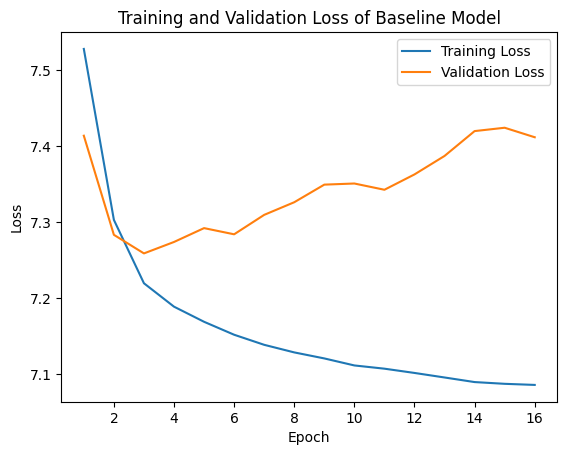

In [ ]:
ModelEvaluation.plot_loss(baseline_model.history,'Baseline Model')


								 Baseline Validation Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



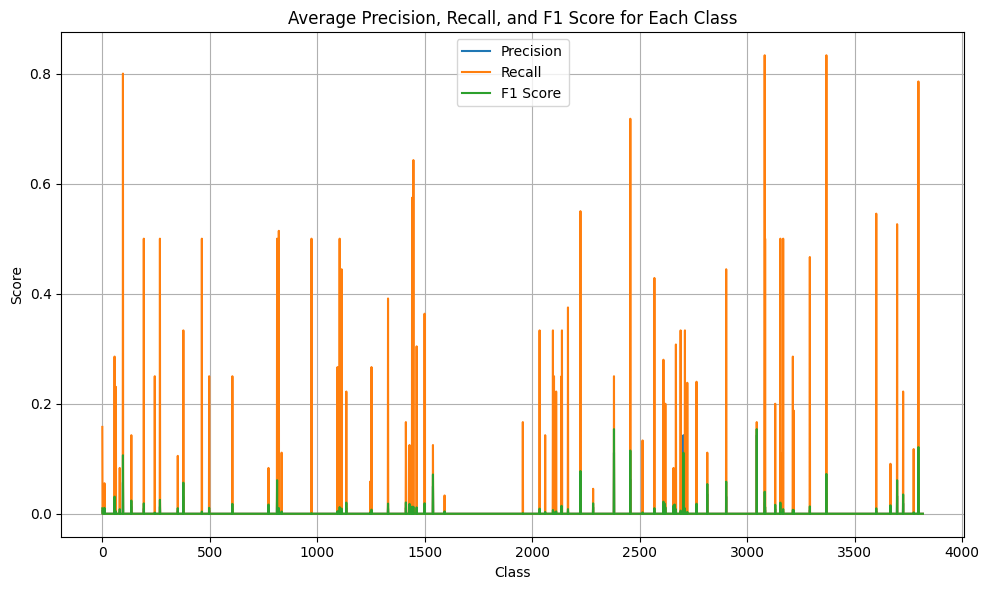

Baseline Validation Evaluation Metrics:
----------------------------------------------------------------------------------------------------
	  Test Loss: 7.411195  					|		 Top 10 Accuracy: 0.053993
	  Mean Reciprocal Rank: 0.027269
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.005399		|					   Precision=0.011779
 				 Recall=0.053993		|					   Recall=0.001149
 				 F1 Score=0.009817		|					   F1 Score=0.002093



In [ ]:
# Evaluating on validation dataset
print("\t\t\t\t\t\t\t\t Baseline Validation Evaluation:")
print("_" * 180, "\n")
baseline_evaluation_metrics_valid = baseline_evaluate_model(baseline_model, baseline_valid_dataset, top_k)

print("=" * 180)
print("Baseline Validation Evaluation Metrics:")
print("-" * 100)
print(f"\t  Test Loss: {baseline_evaluation_metrics_valid['test_loss']:.6f}  \t\t\t\t\t|\t\t Top {top_k} Accuracy: {baseline_evaluation_metrics_valid[f'top_{top_k}_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {baseline_evaluation_metrics_valid['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={baseline_evaluation_metrics_valid['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={baseline_evaluation_metrics_valid['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={baseline_evaluation_metrics_valid['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={baseline_evaluation_metrics_valid['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={baseline_evaluation_metrics_valid['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={baseline_evaluation_metrics_valid['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")


									Baseline Test Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



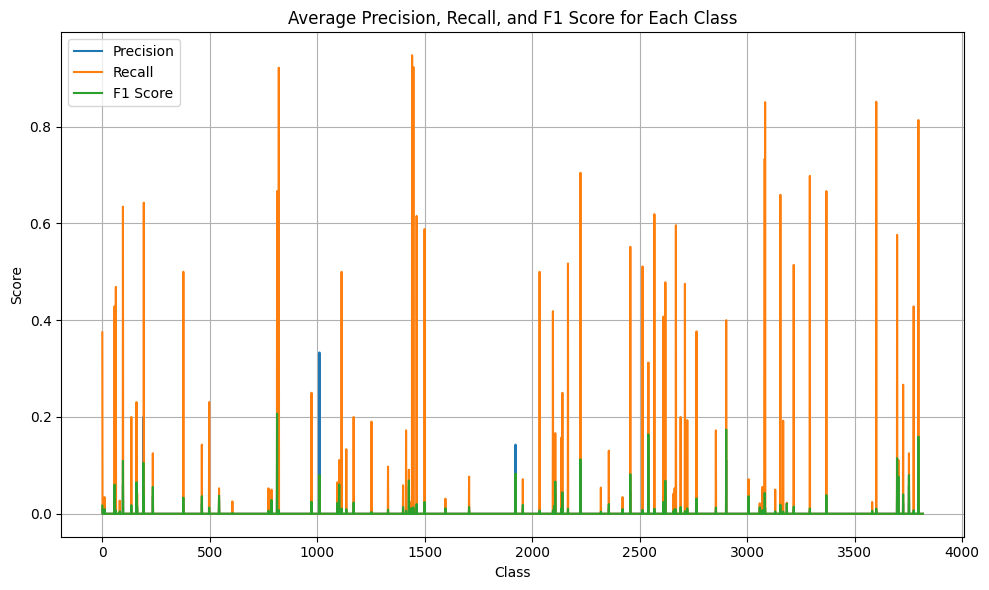

Baseline Test Evaluation Metrics:
----------------------------------------------------------------------------------------------------
	  Test Loss: 7.263458  					|		 Top 10 Accuracy: 0.068185
	  Mean Reciprocal Rank: 0.033188
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.006818		|					   Precision=0.017947
 				 Recall=0.068185		|					   Recall=0.001153
 				 F1 Score=0.012397		|					   F1 Score=0.002168



In [ ]:
# Evaluating on test dataset
print(f"\t\t\t\t\t\t\t\t\tBaseline Test Evaluation:")
print("_" * 180, "\n")
baseline_evaluation_metrics_test = baseline_evaluate_model(baseline_model, baseline_test_dataset, top_k)

print("=" * 180)
print("Baseline Test Evaluation Metrics:")
print("-" * 100)
print(f"\t  Test Loss: {baseline_evaluation_metrics_test['test_loss']:.6f}  \t\t\t\t\t|\t\t Top {top_k} Accuracy: {baseline_evaluation_metrics_test[f'top_{top_k}_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {baseline_evaluation_metrics_test['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={baseline_evaluation_metrics_test['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={baseline_evaluation_metrics_test['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={baseline_evaluation_metrics_test['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={baseline_evaluation_metrics_test['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={baseline_evaluation_metrics_test['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={baseline_evaluation_metrics_test['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")


## Adjusted Epoch:
______________________________________________________________________________________________________

In [ ]:
# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================

filter_size = 32
kernel_size = 3
dropout = 0.2
learning_rate = 0.001
optimizer = 'adam'
activation_function = 'tanh'

num_epochs = 4
num_prop = property_profile_array.shape[0]
top_k = 10

# ==================================================================================================================================

print(f"Hyperparameters: Filter Size={filter_size}, Kernel Size={kernel_size}, Dropout={dropout}, "
      f"Learning Rate={learning_rate}, Optimizer={optimizer}, Activation Function={activation_function}")

# Instantiate the InteractionModel for multi-class classification
baseline_model = InteractionModel_baseline(num_prop, filter_size, kernel_size, dropout, activation_function)
if optimizer == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
else:
    raise ValueError("Unknown optimizer: " + optimizer)

# Compiling the model with the optimizer instance
baseline_model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Shuffle and prefetch the training dataset for better performance
baseline_train_dataset = baseline_train_dataset.shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Training the baseline model
baseline_model.fit(baseline_train_dataset, epochs=num_epochs, validation_data=baseline_valid_dataset)


Hyperparameters: Filter Size=32, Kernel Size=3, Dropout=0.2, Learning Rate=0.001, Optimizer=adam, Activation Function=tanh
Epoch 1/4
3671/3671 [==============================] - 23s 5ms/step - loss: 7.5176 - accuracy: 0.0058 - val_loss: 7.3883 - val_accuracy: 0.0072
Epoch 2/4
3671/3671 [==============================] - 20s 5ms/step - loss: 7.2835 - accuracy: 0.0096 - val_loss: 7.2745 - val_accuracy: 0.0091
Epoch 3/4
3671/3671 [==============================] - 20s 5ms/step - loss: 7.2227 - accuracy: 0.0090 - val_loss: 7.2585 - val_accuracy: 0.0104
Epoch 4/4
3671/3671 [==============================] - 21s 5ms/step - loss: 7.1944 - accuracy: 0.0094 - val_loss: 7.2620 - val_accuracy: 0.0097


In [ ]:
# Print the model summary
baseline_model.summary()

Model: "interaction_model_baseline_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           multiple                  128       
                                                                 
 conv1d_9 (Conv1D)           multiple                  3104      
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 conv1d_10 (Conv1D)          multiple                  3104      
                                                                 
 conv1d_11 (Conv1D)          multiple                  3104      
                                                                 
 global_max_pooling1d_2 (Gl  multiple                  0         
 obalMaxPooling1D)                                               
                                      

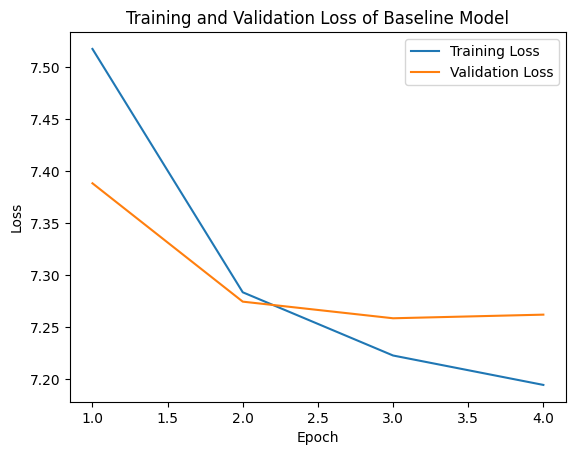

In [ ]:
ModelEvaluation.plot_loss(baseline_model.history,'Baseline Model')


								 Baseline Validation Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



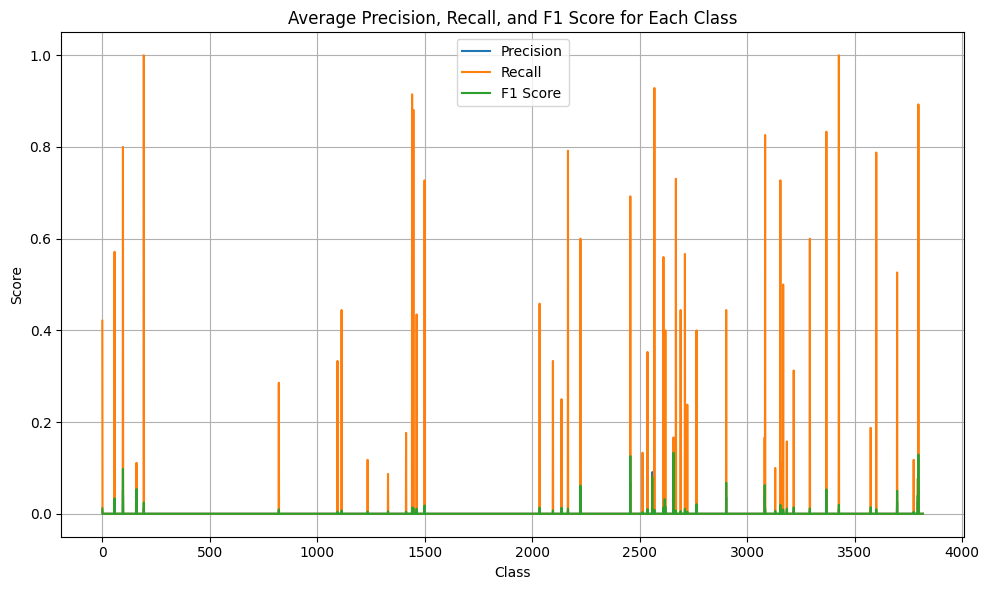

Baseline Validation Evaluation Metrics:
----------------------------------------------------------------------------------------------------
	  Test Loss: 7.261456  					|		 Top 10 Accuracy: 0.064601
	  Mean Reciprocal Rank: 0.030600
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.006460		|					   Precision=0.017135
 				 Recall=0.064601		|					   Recall=0.000949
 				 F1 Score=0.011746		|					   F1 Score=0.001798



In [ ]:
# Evaluating on validation dataset
print("\t\t\t\t\t\t\t\t Baseline Validation Evaluation:")
print("_" * 180, "\n")
baseline_evaluation_metrics_valid = baseline_evaluate_model(baseline_model, baseline_valid_dataset, top_k)

print("=" * 180)
print("Baseline Validation Evaluation Metrics:")
print("-" * 100)
print(f"\t  Test Loss: {baseline_evaluation_metrics_valid['test_loss']:.6f}  \t\t\t\t\t|\t\t Top {top_k} Accuracy: {baseline_evaluation_metrics_valid[f'top_{top_k}_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {baseline_evaluation_metrics_valid['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={baseline_evaluation_metrics_valid['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={baseline_evaluation_metrics_valid['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={baseline_evaluation_metrics_valid['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={baseline_evaluation_metrics_valid['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={baseline_evaluation_metrics_valid['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={baseline_evaluation_metrics_valid['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")


									Baseline Test Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



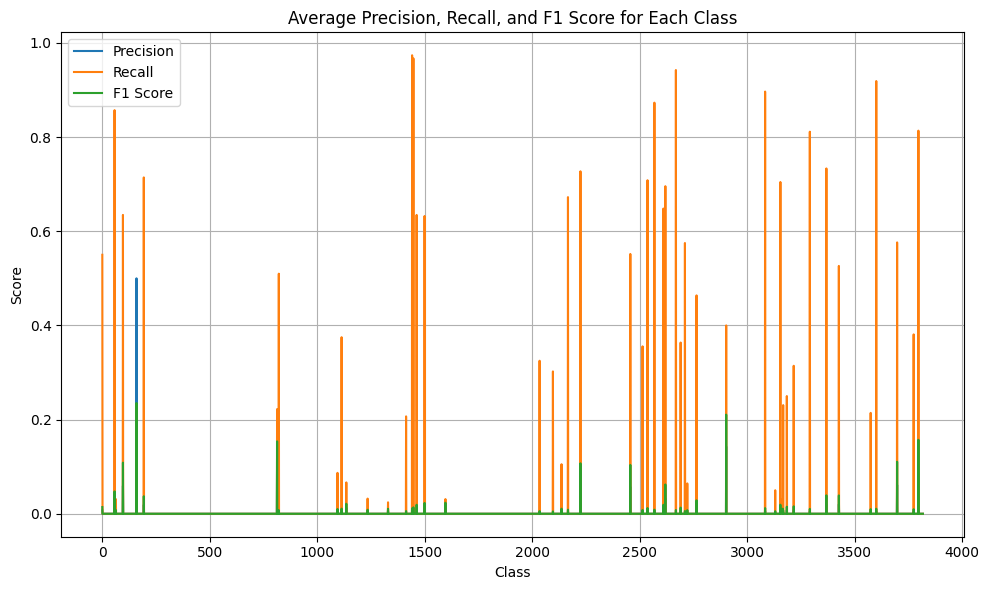

Baseline Test Evaluation Metrics:
----------------------------------------------------------------------------------------------------
	  Test Loss: 7.252962  					|		 Top 10 Accuracy: 0.068304
	  Mean Reciprocal Rank: 0.032073
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.006830		|					   Precision=0.017883
 				 Recall=0.068304		|					   Recall=0.000956
 				 F1 Score=0.012419		|					   F1 Score=0.001815



In [ ]:
# Evaluating on test dataset
print(f"\t\t\t\t\t\t\t\t\tBaseline Test Evaluation:")
print("_" * 180, "\n")
baseline_evaluation_metrics_test = baseline_evaluate_model(baseline_model, baseline_test_dataset, top_k)

print("=" * 180)
print("Baseline Test Evaluation Metrics:")
print("-" * 100)
print(f"\t  Test Loss: {baseline_evaluation_metrics_test['test_loss']:.6f}  \t\t\t\t\t|\t\t Top {top_k} Accuracy: {baseline_evaluation_metrics_test[f'top_{top_k}_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {baseline_evaluation_metrics_test['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={baseline_evaluation_metrics_test['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={baseline_evaluation_metrics_test['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={baseline_evaluation_metrics_test['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={baseline_evaluation_metrics_test['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={baseline_evaluation_metrics_test['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={baseline_evaluation_metrics_test['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")


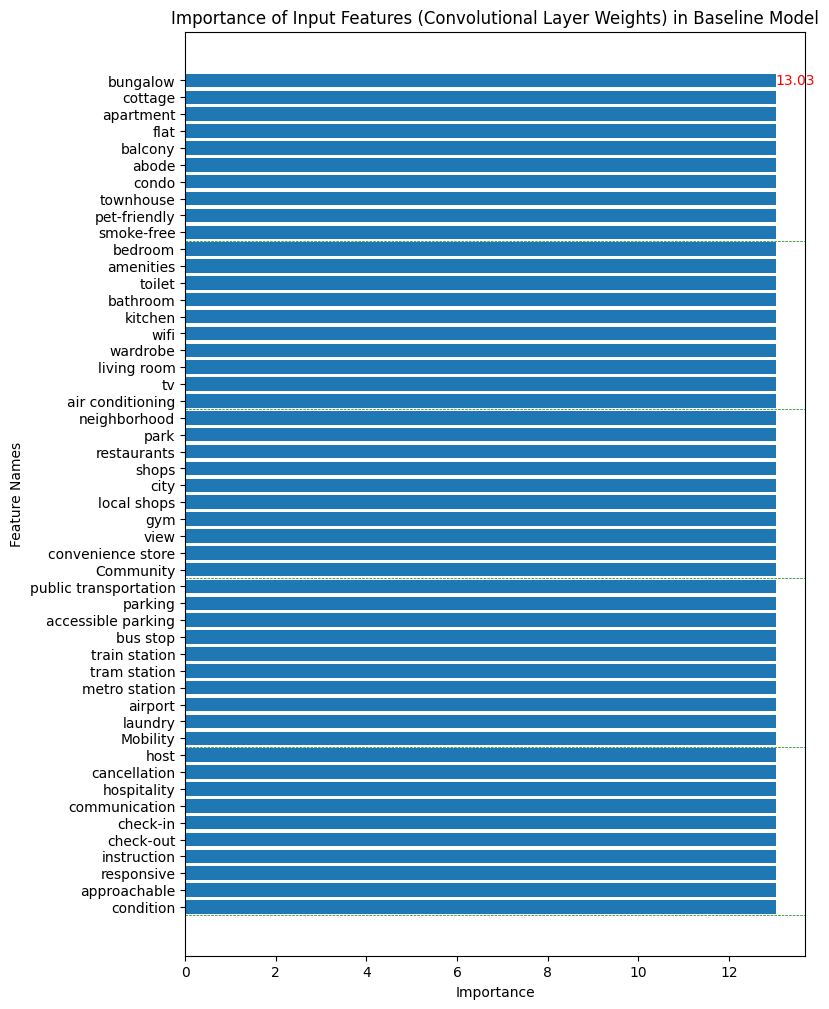

In [ ]:
ModelEvaluation.plot_feature_importance(baseline_model, all_seed_words,'Baseline Model')

In [ ]:


# Saving the trained model
baseline_model.save(main_data_path + "baseline_model", save_format='tf')

______________________________________________________________________________________________________
# **Proposed Model**
______________________________________________________________________________________________________

## **Data Preparation for Proposed Model (CNN using User Profile & Property profile):** <a name="data_prep"></a>
______________________________________________________________________________________________________

In [ ]:
# Function to create batches manually
def proposed_model_create_batches(user_profiles, property_profiles, interaction_labels, batch_size):
    """
    Create batches of data for training or evaluation.

    Input:
    - user_profiles (numpy.ndarray): Array containing user profiles.
    - property_profiles (numpy.ndarray): Array containing property profiles.
    - interaction_labels (numpy.ndarray): Array containing interaction labels.
    - batch_size (int): Size of each batch.

    Yields:
    - tuple: A tuple containing inputs and labels for each batch. The inputs are a tuple of user profiles and property profiles,
             and the labels are interaction labels.
    """
    num_samples = len(user_profiles)
    for i in range(0, num_samples, batch_size):
        batch_user_profiles = user_profiles[i:i+batch_size]
        batch_property_profiles = property_profiles  # Updated to use batch-wise property profiles
        batch_interaction_labels = interaction_labels[i:i+batch_size]
        yield (batch_user_profiles, batch_property_profiles), batch_interaction_labels


# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================
batch_size = 16
# ==================================================================================================================================

proposed_model_train_dataset = tf.data.Dataset.from_generator(
    lambda: proposed_model_create_batches(train_user_profile_array, property_profile_array, train_ground_truth_interaction_array, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 50), dtype=tf.float32),  # User profile shape
            tf.TensorSpec(shape=(3818, 50), dtype=tf.float32),  # Property profile shape
        ),
        tf.TensorSpec(shape=(None, 3818), dtype=tf.float32)  # Interaction labels shape
    )
)

proposed_model_valid_dataset = tf.data.Dataset.from_generator(
    lambda: proposed_model_create_batches(valid_user_profile_array, property_profile_array, valid_ground_truth_interaction_array, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 50), dtype=tf.float32),  # User profile shape
            tf.TensorSpec(shape=(3818, 50), dtype=tf.float32),  # Property profile shape
        ),
        tf.TensorSpec(shape=(None, 3818), dtype=tf.float32)  # Interaction labels shape
    )
)


proposed_model_test_dataset = tf.data.Dataset.from_generator(
    lambda: proposed_model_create_batches(test_user_profile_array, property_profile_array, test_ground_truth_interaction_array, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 50), dtype=tf.float32),           # User profile shape
            tf.TensorSpec(shape=(3818, 50), dtype=tf.float32),     # Property profile shape
        ),tf.TensorSpec(shape=(None, 3818), dtype=tf.float32)          # Interaction labels shape
    )
)

## **Training & Evaluating Proposed Model (CNN using User Profile & Property profile):** <a name="data_prep"></a>
______________________________________________________________________________________________________

In [ ]:

class Proposed_InteractionModel(tf.keras.Model):
    """
    A class representing the proposed interaction model.

    Methods:
    - __init__(self, num_classes, filters, kernel_size, dropout_rate, activation): Initialize the interaction model with specified parameters.
    - call(self, inputs): Perform forward pass through the interaction model.
    - train_step(self, data): Perform one training step on the interaction model.

    Input:
    - num_classes (int): Number of classes for classification.
    - filters (int): Number of filters in convolutional layers.
    - kernel_size (int): Size of the convolutional kernel.
    - dropout_rate (float): Dropout rate for dropout layers.
    - activation (str): Activation function for convolutional layers.

    Returns:
    - interaction_probability (tf.Tensor): Output probabilities of interactions.
    """
    def __init__(self, num_classes, filters, kernel_size, dropout_rate, activation):
        super(Proposed_InteractionModel, self).__init__()

        self.num_classes = num_classes

        # Layers Definition
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')

        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

        self.conv1d_3 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        self.conv1d_4 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')

        self.global_max_pooling = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)

        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')



    def call(self, inputs):
        """
        Perform forward pass through the interaction model.

        Input:
        - inputs (tuple): A tuple containing user profiles and property profiles.

        Returns:
        - interaction_probability (tf.Tensor): Output probabilities of interactions.
        """
        user_profile, property_profile = inputs  # Extracting the inputs

        # Reshaping user_profile to (batch_size, 1, 50) to make it compatible for elmentwise multiplication
        user_profile_reshaped = tf.expand_dims(user_profile, axis=1)

        # Reshaping property_profile to (1, 3818, 50) to make it compatible for elmentwise multiplication
        property_profile_reshaped = tf.expand_dims(property_profile, axis=0)

        # Performing element-wise multiplication to conmbine user and property profile to pass it to the model
        elementwise_product = user_profile_reshaped * property_profile_reshaped  # Shape: (batch_size, 3818, 50)

        conv1d_output_1 = self.conv1d_1(elementwise_product)
        conv1d_output_2 = self.conv1d_2(conv1d_output_1)

        # Applying dropout after the second convolutional layer
        dropout_output_1 = self.dropout_1(conv1d_output_2)

        conv1d_output_3 = self.conv1d_3(dropout_output_1)
        conv1d_output_4 = self.conv1d_4(conv1d_output_3)

        max_pooled_output = self.global_max_pooling(conv1d_output_4)

        # Applying dropout at the end of the model
        dropout_output_2 = self.dropout_2(max_pooled_output)

        # Generating output probabilities
        interaction_probability = self.output_layer(dropout_output_2)

        return interaction_probability

    def train_step(self, data):
        """
        Perform one training step on the interaction model.

        Input:
        - data (tuple): A tuple containing inputs and interaction labels.

        Returns:
        - dict: A dictionary containing the results of training step.
        """
        inputs, interaction_labels = data
        user_profiles, property_profiles = inputs

        with tf.GradientTape() as tape:
            interaction_probability = self((user_profiles, property_profiles), training=True)  # Forward pass
            loss = self.compiled_loss(interaction_labels, interaction_probability)  # Compute loss

        gradients = tape.gradient(loss, self.trainable_variables)  # Compute gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))  # Update weights

        self.compiled_metrics.update_state(interaction_labels, interaction_probability)  # Update metrics
        return {m.name: m.result() for m in self.metrics}



In [ ]:
def evaluate_proposed_model(model, test_dataset, top_k=5):
    """
    Testing the model on a test dataset and computing various evaluation metrics.

    Inputs:
    - model: The trained model
    - test_dataset: TensorFlow dataset
    - top_k: Top-k value for top-k accuracy (default is 5)

    Outputs:
    - metrics_dict: A dictionary containing various evaluation metrics
    """
    test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
    interaction_probabilities = []
    interaction_labels_list = []

    for batch in test_dataset:
        inputs, interaction_labels = batch
        user_profiles, property_profiles = inputs
        interaction_probability = model((user_profiles, property_profiles), training=False)
        interaction_probabilities.append(interaction_probability.numpy())  # Convert tensor to numpy array
        interaction_labels_list.append(interaction_labels.numpy())  # Convert tensor to numpy array
        test_loss = model.compiled_loss(interaction_labels, interaction_probability)
        test_loss_metric.update_state(test_loss)

    interaction_probabilities = np.concatenate(interaction_probabilities, axis=0)  # Convert to numpy array
    interaction_labels_concatenated = np.concatenate(interaction_labels_list, axis=0)  # Convert to numpy array


    mean_reciprocal_rank = ModelEvaluation.mean_reciprocal_rank(interaction_probabilities, interaction_labels_concatenated)

    #  Computing top-k accuracy using the static method from ModelEvaluation class
    top_k_accuracy = ModelEvaluation.top_k_accuracy(interaction_probabilities, interaction_labels_concatenated, k=top_k)


    test_loss = test_loss_metric.result().numpy()

   #  Computing other metrics using the static methods from ModelEvaluation class
    _,_,_,micro_class_avg_precision, micro_class_avg_recall, micro_class_avg_f1_score = ModelEvaluation.class_based_precision_recall_f1(interaction_probabilities, interaction_labels_concatenated, top_k)

    #  Instance-based metrics
    _,_,_,micro_instance_avg_precision, micro_instance_avg_recall, micro_instance_avg_f1_score = ModelEvaluation.instance_based_precision_recall_f1(interaction_probabilities, interaction_labels_concatenated, top_k)

    #  Creating a dictionary to store the metrics
    metrics_dict = {
        'test_loss': test_loss,
        f'top_{top_k}_accuracy': top_k_accuracy,
        'micro_class_avg_precision': micro_class_avg_precision,
        'micro_class_avg_recall': micro_class_avg_recall,
        'micro_class_avg_f1_score': micro_class_avg_f1_score,
        'mean_reciprocal_rank': mean_reciprocal_rank,
        'micro_instance_avg_precision': micro_instance_avg_precision,
        'micro_instance_avg_recall': micro_instance_avg_recall,
        'micro_instance_avg_f1_score': micro_instance_avg_f1_score
    }

    return metrics_dict



In [ ]:
# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================

filter_size = 32
kernel_size = 3
dropout = 0.3
learning_rate = 0.001
optimizer = 'adam'
activation_function = 'tanh'

num_epochs = 17
num_prop = property_profile_array.shape[0]
top_k = 10
# =================================================================================================================================

print(f"Hyperparameters: Filter Size={filter_size}, Kernel Size={kernel_size}, Dropout={dropout}, "
      f"Learning Rate={learning_rate}, Optimizer={optimizer}, Activation Function={activation_function}")

# Instantiate the InteractionModel for multi-class classification
proposed_model = Proposed_InteractionModel(num_prop, filter_size, kernel_size, dropout, activation_function)
if optimizer == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
else:
    raise ValueError("Unknown optimizer: " + optimizer)

# Compiling the model with the created optimizer instance
proposed_model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Shuffle and prefetch the training dataset for better performance
proposed_model_train_dataset = proposed_model_train_dataset.shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Training the proposed model
proposed_model.fit(proposed_model_train_dataset, epochs=num_epochs, validation_data=proposed_model_valid_dataset)



Hyperparameters: Filter Size=32, Kernel Size=3, Dropout=0.3, Learning Rate=0.001, Optimizer=adam, Activation Function=tanh
Epoch 1/17
3671/3671 [==============================] - 30s 6ms/step - loss: 7.5247 - accuracy: 0.0058 - val_loss: 7.4068 - val_accuracy: 0.0074
Epoch 2/17
3671/3671 [==============================] - 28s 6ms/step - loss: 7.2708 - accuracy: 0.0092 - val_loss: 7.3216 - val_accuracy: 0.0081
Epoch 3/17
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1836 - accuracy: 0.0105 - val_loss: 7.3047 - val_accuracy: 0.0104
Epoch 4/17
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1335 - accuracy: 0.0115 - val_loss: 7.3011 - val_accuracy: 0.0086
Epoch 5/17
3671/3671 [==============================] - 28s 6ms/step - loss: 7.0964 - accuracy: 0.0118 - val_loss: 7.2921 - val_accuracy: 0.0097
Epoch 6/17
3671/3671 [==============================] - 28s 6ms/step - loss: 7.0686 - accuracy: 0.0113 - val_loss: 7.3030 - val_accuracy: 0.0110
Epoch 7

In [ ]:
proposed_model.summary()

Model: "proposed__interaction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          multiple                  4832      
                                                                 
 conv1d_13 (Conv1D)          multiple                  3104      
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 conv1d_14 (Conv1D)          multiple                  3104      
                                                                 
 conv1d_15 (Conv1D)          multiple                  3104      
                                                                 
 global_max_pooling1d_3 (Gl  multiple                  0         
 obalMaxPooling1D)                                               
                                       

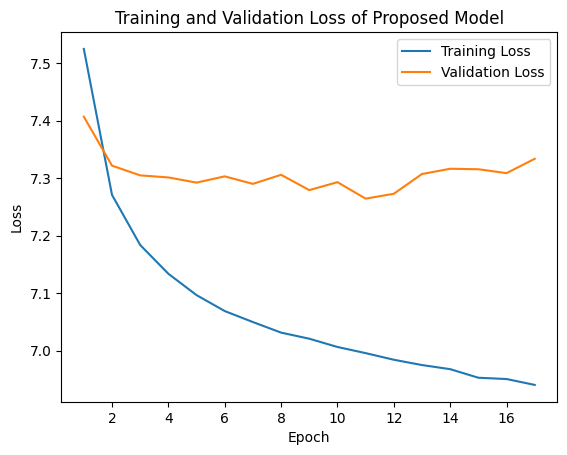

In [ ]:
ModelEvaluation.plot_loss(proposed_model.history,'Proposed Model')


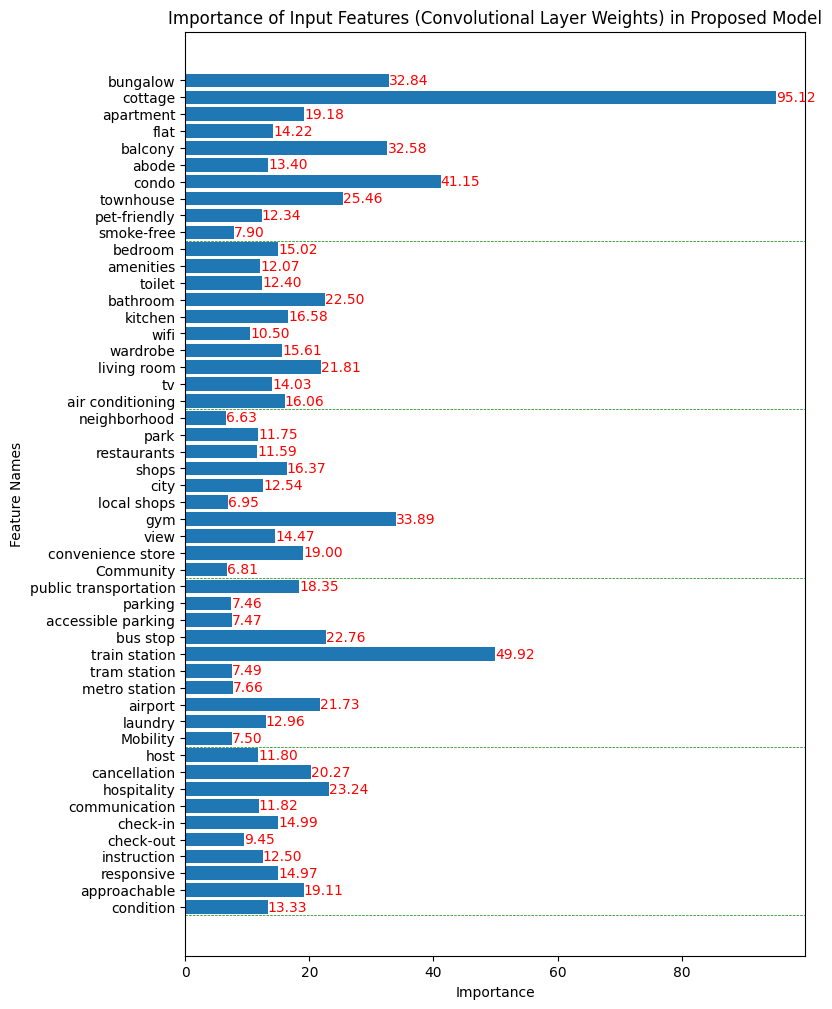

In [ ]:
ModelEvaluation.plot_feature_importance(proposed_model, all_seed_words,'Proposed Model')

								 Proposed Model Validation Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



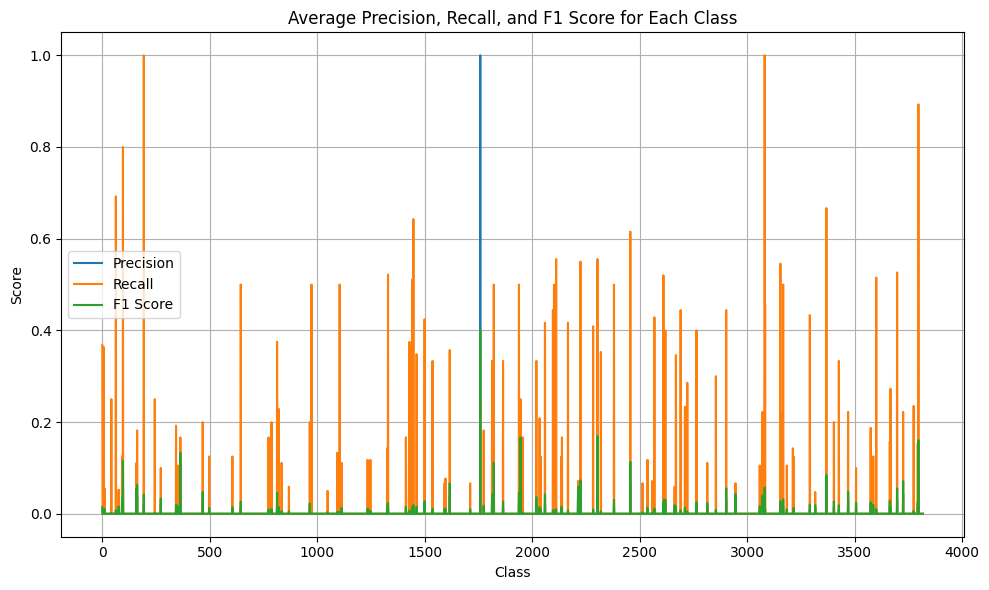

Proposed Model Validation Evaluation Metrics:
--------------------------------------------------------------------------------------------------------------------------------
	  Test Loss: 7.332585  					|		 Top 10 Accuracy: 0.066746
	  Mean Reciprocal Rank: 0.032361
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.006675		|					   Precision=0.012830
 				 Recall=0.066746		|					   Recall=0.001392
 				 F1 Score=0.012136		|					   F1 Score=0.002511



In [ ]:
# Evaluating on validation dataset
print("\t\t\t\t\t\t\t\t Proposed Model Validation Evaluation:")
print("_" * 180, "\n")

proposed_model_evaluation_metrics_valid = evaluate_proposed_model(proposed_model, proposed_model_valid_dataset, top_k)

print("=" * 180)
print("Proposed Model Validation Evaluation Metrics:")
print("-" * 128)
print(f"\t  Test Loss: {proposed_model_evaluation_metrics_valid['test_loss']:.6f}  \t\t\t\t\t|\t\t Top {top_k} Accuracy: {proposed_model_evaluation_metrics_valid['top_10_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {proposed_model_evaluation_metrics_valid['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={proposed_model_evaluation_metrics_valid['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={proposed_model_evaluation_metrics_valid['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={proposed_model_evaluation_metrics_valid['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={proposed_model_evaluation_metrics_valid['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={proposed_model_evaluation_metrics_valid['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={proposed_model_evaluation_metrics_valid['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")


								 Proposed Model Test Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



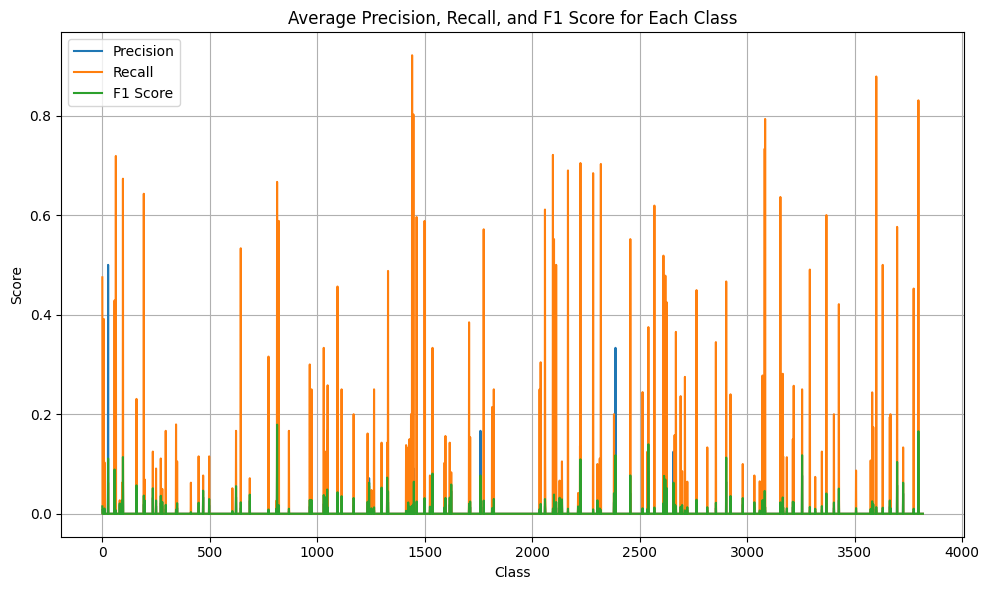

Proposed Model Test Evaluation Metrics:
--------------------------------------------------------------------------------------------------------------------------------
	  Test Loss: 7.137924  					|		 Top 10 Accuracy: 0.086363
	  Mean Reciprocal Rank: 0.041335
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.008636		|					   Precision=0.019195
 				 Recall=0.086363		|					   Recall=0.001594
 				 F1 Score=0.015702		|					   F1 Score=0.002944



In [ ]:
# Evaluating on test dataset
print("\t\t\t\t\t\t\t\t Proposed Model Test Evaluation:")
print("_" * 180, "\n")

proposed_model_evaluation_metrics_test = evaluate_proposed_model(proposed_model, proposed_model_test_dataset, top_k)


print("=" * 180)
print("Proposed Model Test Evaluation Metrics:")
print("-" * 128)
print(f"\t  Test Loss: {proposed_model_evaluation_metrics_test['test_loss']:.6f}  \t\t\t\t\t|\t\t Top 10 Accuracy: {proposed_model_evaluation_metrics_test['top_10_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {proposed_model_evaluation_metrics_test['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={proposed_model_evaluation_metrics_test['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={proposed_model_evaluation_metrics_test['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={proposed_model_evaluation_metrics_test['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={proposed_model_evaluation_metrics_test['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={proposed_model_evaluation_metrics_test['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={proposed_model_evaluation_metrics_test['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")

## Less Epoch =14
______________________________________________________________________________________________________

In [ ]:
# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================

filter_size = 32
kernel_size = 3
dropout = 0.3
learning_rate = 0.001
optimizer = 'adam'
activation_function = 'tanh'

num_epochs = 14
num_prop = property_profile_array.shape[0]
top_k = 10
# =================================================================================================================================

print(f"Hyperparameters: Filter Size={filter_size}, Kernel Size={kernel_size}, Dropout={dropout}, "
      f"Learning Rate={learning_rate}, Optimizer={optimizer}, Activation Function={activation_function}")

# Instantiate the InteractionModel for multi-class classification
proposed_model_1 = Proposed_InteractionModel(num_prop, filter_size, kernel_size, dropout, activation_function)
if optimizer == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
else:
    raise ValueError("Unknown optimizer: " + optimizer)

# Compiling the model with the created optimizer instance
proposed_model_1.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Shuffle and prefetch the training dataset for better performance
proposed_model_train_dataset = proposed_model_train_dataset.shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Training the proposed model
proposed_model_1.fit(proposed_model_train_dataset, epochs=num_epochs, validation_data=proposed_model_valid_dataset)



Hyperparameters: Filter Size=32, Kernel Size=3, Dropout=0.3, Learning Rate=0.001, Optimizer=adam, Activation Function=tanh
Epoch 1/14
3671/3671 [==============================] - 29s 6ms/step - loss: 7.5157 - accuracy: 0.0061 - val_loss: 7.3836 - val_accuracy: 0.0086
Epoch 2/14
3671/3671 [==============================] - 28s 6ms/step - loss: 7.2926 - accuracy: 0.0089 - val_loss: 7.2767 - val_accuracy: 0.0087
Epoch 3/14
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1942 - accuracy: 0.0103 - val_loss: 7.2972 - val_accuracy: 0.0098
Epoch 4/14
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1443 - accuracy: 0.0113 - val_loss: 7.3180 - val_accuracy: 0.0100
Epoch 5/14
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1109 - accuracy: 0.0109 - val_loss: 7.2940 - val_accuracy: 0.0093
Epoch 6/14
3671/3671 [==============================] - 28s 6ms/step - loss: 7.0868 - accuracy: 0.0114 - val_loss: 7.3114 - val_accuracy: 0.0089
Epoch 7

In [ ]:
proposed_model_1.summary()

Model: "proposed__interaction_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          multiple                  4832      
                                                                 
 conv1d_17 (Conv1D)          multiple                  3104      
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 conv1d_18 (Conv1D)          multiple                  3104      
                                                                 
 conv1d_19 (Conv1D)          multiple                  3104      
                                                                 
 global_max_pooling1d_4 (Gl  multiple                  0         
 obalMaxPooling1D)                                               
                                     

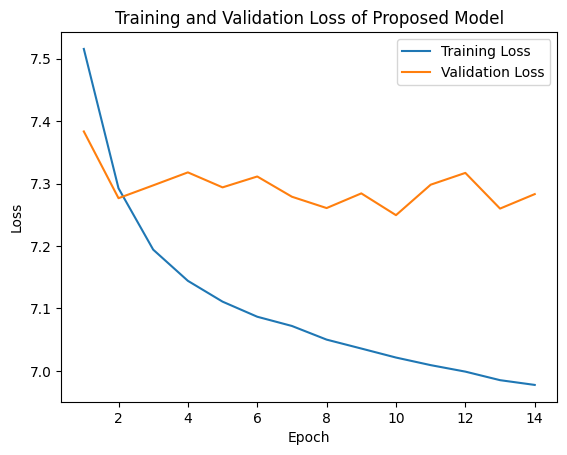

In [ ]:
ModelEvaluation.plot_loss(proposed_model_1.history,'Proposed Model')


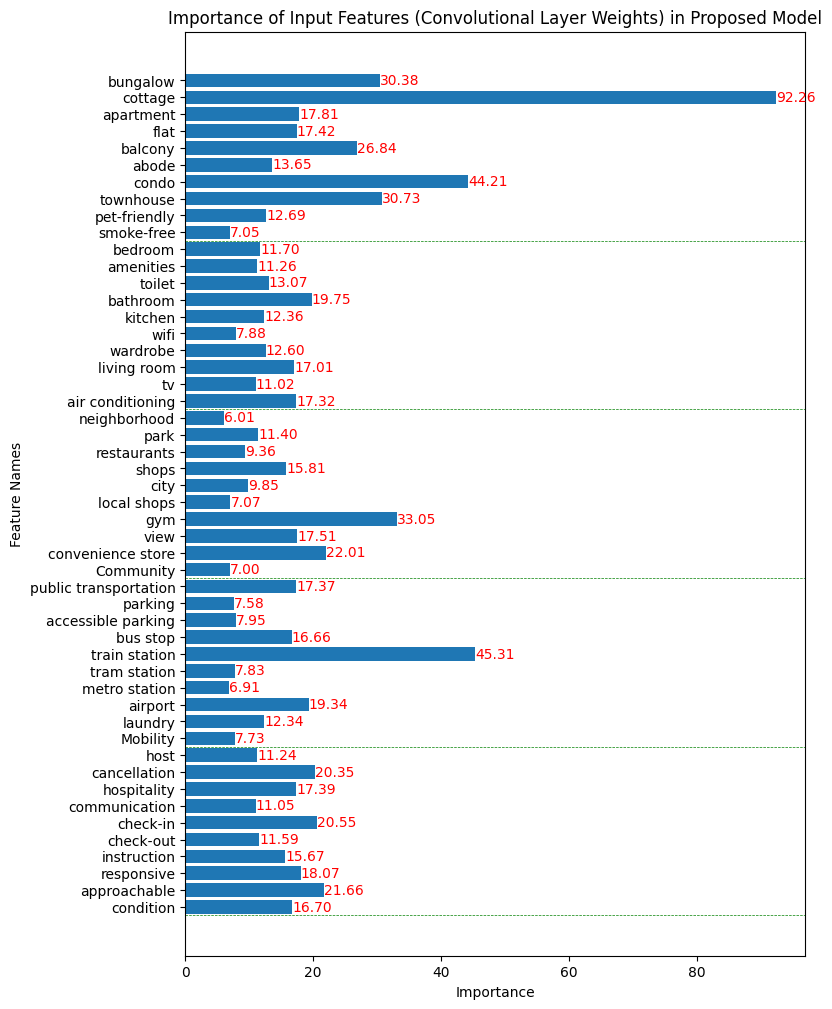

In [ ]:
ModelEvaluation.plot_feature_importance(proposed_model_1, all_seed_words,'Proposed Model')

								 Proposed Model Validation Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



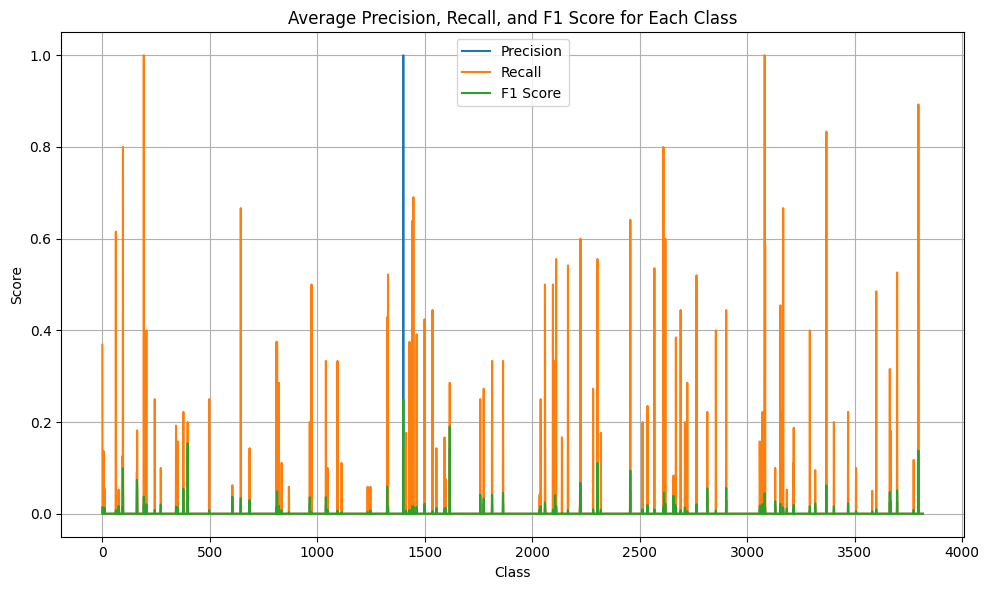

Proposed Model Validation Evaluation Metrics:
--------------------------------------------------------------------------------------------------------------------------------
	  Test Loss: 7.282474  					|		 Top 10 Accuracy: 0.070799
	  Mean Reciprocal Rank: 0.034827
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.007080		|					   Precision=0.016391
 				 Recall=0.070799		|					   Recall=0.001525
 				 F1 Score=0.012872		|					   F1 Score=0.002791



In [ ]:
# Evaluating on validation dataset
print("\t\t\t\t\t\t\t\t Proposed Model Validation Evaluation:")
print("_" * 180, "\n")

proposed_model_evaluation_metrics_valid_1 = evaluate_proposed_model(proposed_model_1, proposed_model_valid_dataset, top_k)

print("=" * 180)
print("Proposed Model Validation Evaluation Metrics:")
print("-" * 128)
print(f"\t  Test Loss: {proposed_model_evaluation_metrics_valid_1['test_loss']:.6f}  \t\t\t\t\t|\t\t Top 10 Accuracy: {proposed_model_evaluation_metrics_valid_1['top_10_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {proposed_model_evaluation_metrics_valid_1['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={proposed_model_evaluation_metrics_valid_1['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={proposed_model_evaluation_metrics_valid_1['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={proposed_model_evaluation_metrics_valid_1['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={proposed_model_evaluation_metrics_valid_1['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={proposed_model_evaluation_metrics_valid_1['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={proposed_model_evaluation_metrics_valid_1['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")

								 Proposed Model Test Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



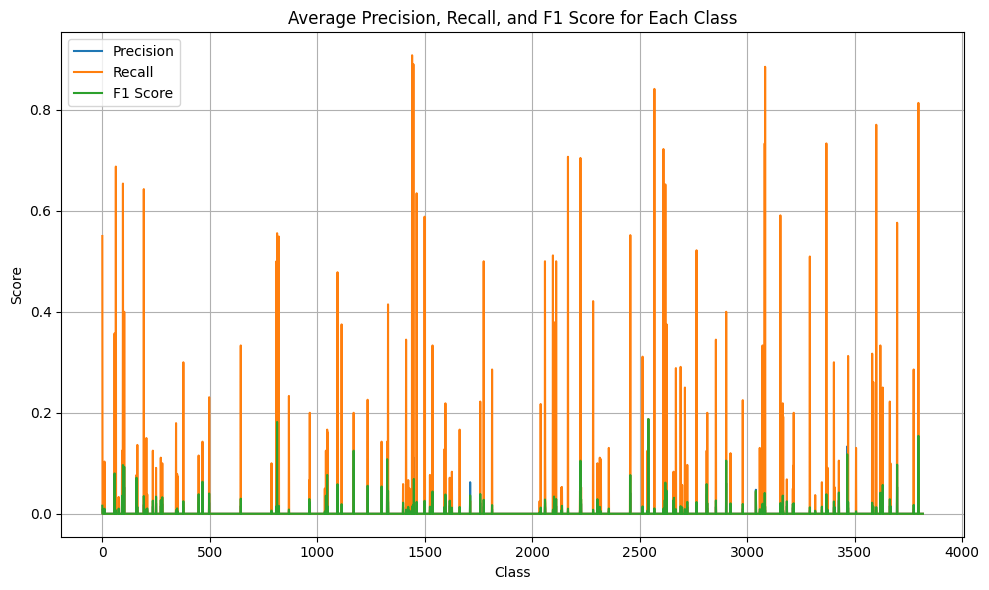

Proposed Model Test Evaluation Metrics:
--------------------------------------------------------------------------------------------------------------------------------
	  Test Loss: 7.158793  					|		 Top 10 Accuracy: 0.084694
	  Mean Reciprocal Rank: 0.041223
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.008469		|					   Precision=0.018253
 				 Recall=0.084694		|					   Recall=0.001539
 				 F1 Score=0.015399		|					   F1 Score=0.002838



In [ ]:
# Evaluating on test dataset
print("\t\t\t\t\t\t\t\t Proposed Model Test Evaluation:")
print("_" * 180, "\n")

proposed_model_evaluation_metrics_test_1 = evaluate_proposed_model(proposed_model_1, proposed_model_test_dataset, top_k)


print("=" * 180)
print("Proposed Model Test Evaluation Metrics:")
print("-" * 128)
print(f"\t  Test Loss: {proposed_model_evaluation_metrics_test_1['test_loss']:.6f}  \t\t\t\t\t|\t\t Top 10 Accuracy: {proposed_model_evaluation_metrics_test_1['top_10_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {proposed_model_evaluation_metrics_test_1['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={proposed_model_evaluation_metrics_test_1['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={proposed_model_evaluation_metrics_test_1['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={proposed_model_evaluation_metrics_test_1['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={proposed_model_evaluation_metrics_test_1['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={proposed_model_evaluation_metrics_test_1['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={proposed_model_evaluation_metrics_test_1['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")

## Less Epoch = 11
______________________________________________________________________________________________________

In [ ]:
# =================================================================================================================================
# ______________________________________________        Hyperparameters    ________________________________________________________
# =================================================================================================================================

filter_size = 32
kernel_size = 3
dropout = 0.3
learning_rate = 0.001
optimizer = 'adam'
activation_function = 'tanh'

num_epochs = 11
num_prop = property_profile_array.shape[0]
top_k = 10
# =================================================================================================================================

print(f"Hyperparameters: Filter Size={filter_size}, Kernel Size={kernel_size}, Dropout={dropout}, "
      f"Learning Rate={learning_rate}, Optimizer={optimizer}, Activation Function={activation_function}")

# Instantiate the InteractionModel for multi-class classification
proposed_model_2 = Proposed_InteractionModel(num_prop, filter_size, kernel_size, dropout, activation_function)
if optimizer == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
else:
    raise ValueError("Unknown optimizer: " + optimizer)

# Compiling the model with the created optimizer instance
proposed_model_2.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Shuffle and prefetch the training dataset for better performance
proposed_model_train_dataset = proposed_model_train_dataset.shuffle(buffer_size=10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Training the proposed model
proposed_model_2.fit(proposed_model_train_dataset, epochs=num_epochs, validation_data=proposed_model_valid_dataset)



Hyperparameters: Filter Size=32, Kernel Size=3, Dropout=0.3, Learning Rate=0.001, Optimizer=adam, Activation Function=tanh
Epoch 1/11
3671/3671 [==============================] - 29s 6ms/step - loss: 7.5213 - accuracy: 0.0061 - val_loss: 7.4063 - val_accuracy: 0.0094
Epoch 2/11
3671/3671 [==============================] - 28s 6ms/step - loss: 7.2965 - accuracy: 0.0090 - val_loss: 7.3293 - val_accuracy: 0.0098
Epoch 3/11
3671/3671 [==============================] - 28s 6ms/step - loss: 7.2132 - accuracy: 0.0096 - val_loss: 7.3136 - val_accuracy: 0.0098
Epoch 4/11
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1685 - accuracy: 0.0102 - val_loss: 7.2985 - val_accuracy: 0.0103
Epoch 5/11
3671/3671 [==============================] - 28s 6ms/step - loss: 7.1244 - accuracy: 0.0109 - val_loss: 7.2673 - val_accuracy: 0.0100
Epoch 6/11
3671/3671 [==============================] - 27s 6ms/step - loss: 7.0928 - accuracy: 0.0118 - val_loss: 7.2637 - val_accuracy: 0.0095
Epoch 7

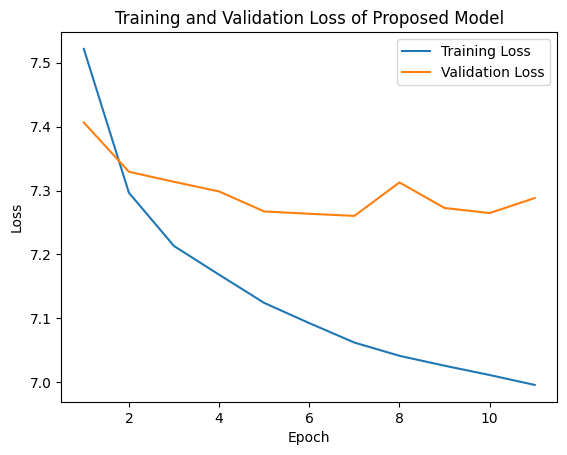

In [ ]:
ModelEvaluation.plot_loss(proposed_model_2.history,'Proposed Model')


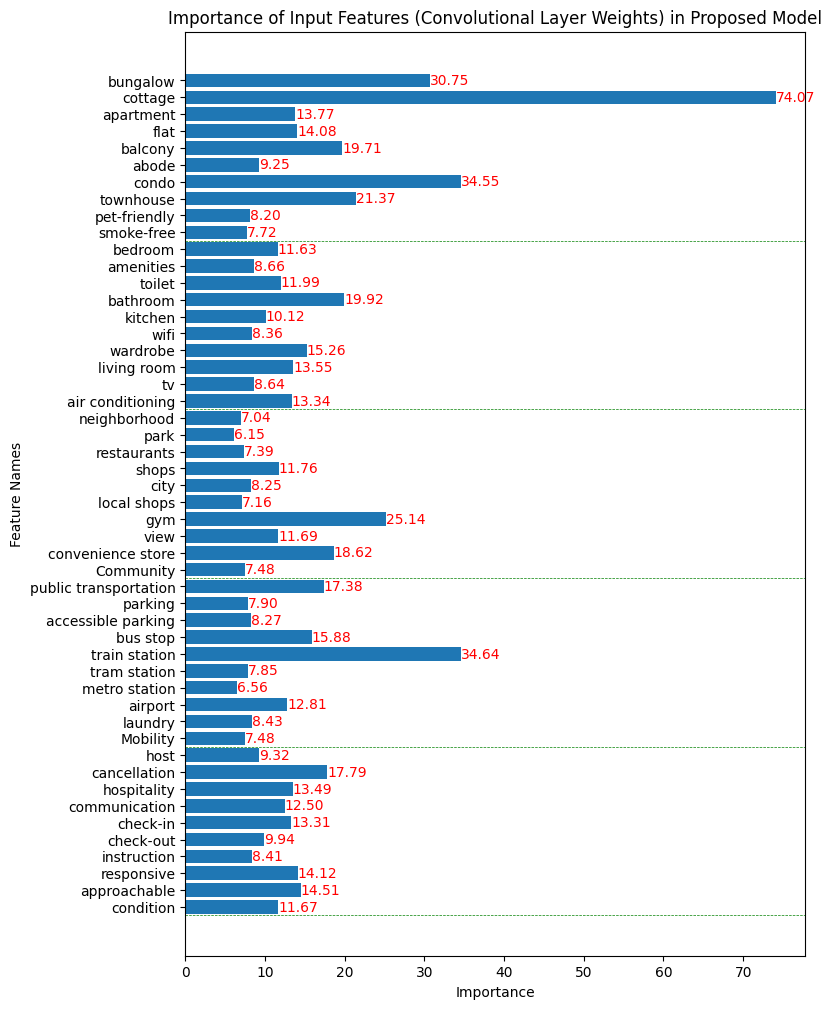

In [ ]:
ModelEvaluation.plot_feature_importance(proposed_model_2, all_seed_words,'Proposed Model')

								 Proposed Model Validation Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



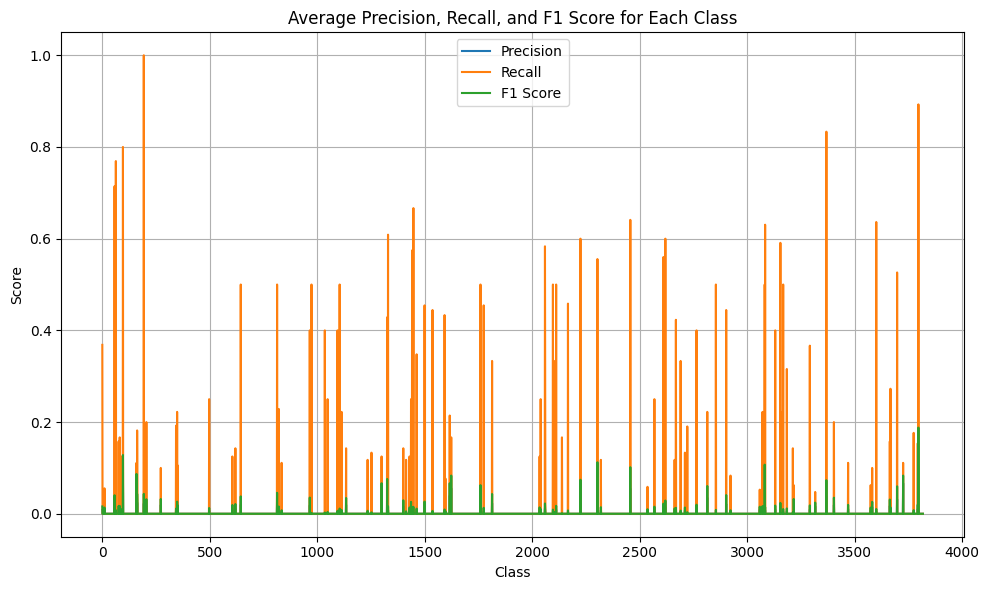

Proposed Model Validation Evaluation Metrics:
--------------------------------------------------------------------------------------------------------------------------------
	  Test Loss: 7.287540  					|		 Top 10 Accuracy: 0.069964
	  Mean Reciprocal Rank: 0.032252
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.006996		|					   Precision=0.014487
 				 Recall=0.069964		|					   Recall=0.001351
 				 F1 Score=0.012721		|					   F1 Score=0.002471



In [ ]:
# Evaluating on validation dataset
print("\t\t\t\t\t\t\t\t Proposed Model Validation Evaluation:")
print("_" * 180, "\n")

proposed_model_evaluation_metrics_valid_2 = evaluate_proposed_model(proposed_model_2, proposed_model_valid_dataset, top_k)

print("=" * 180)
print("Proposed Model Validation Evaluation Metrics:")
print("-" * 128)
print(f"\t  Test Loss: {proposed_model_evaluation_metrics_valid_2['test_loss']:.6f}  \t\t\t\t\t|\t\t Top 10 Accuracy: {proposed_model_evaluation_metrics_valid_2['top_10_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {proposed_model_evaluation_metrics_valid_2['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={proposed_model_evaluation_metrics_valid_2['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={proposed_model_evaluation_metrics_valid_2['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={proposed_model_evaluation_metrics_valid_2['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={proposed_model_evaluation_metrics_valid_2['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={proposed_model_evaluation_metrics_valid_2['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={proposed_model_evaluation_metrics_valid_2['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")

								 Proposed Model Test Evaluation:
____________________________________________________________________________________________________________________________________________________________________________________ 



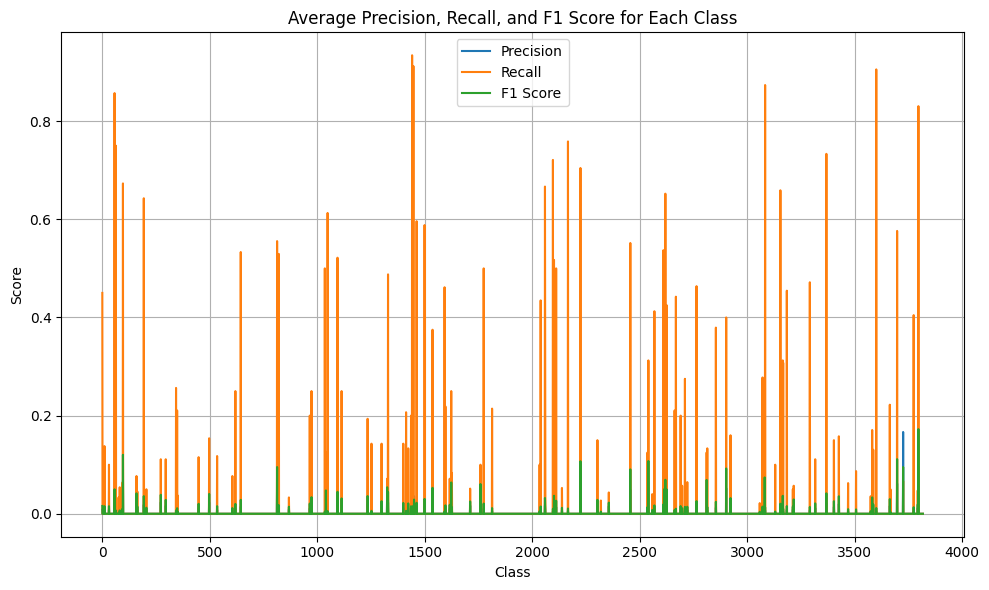

Proposed Model Test Evaluation Metrics:
--------------------------------------------------------------------------------------------------------------------------------
	  Test Loss: 7.146398  					|		 Top 10 Accuracy: 0.082847
	  Mean Reciprocal Rank: 0.039341
	  Micro  Class Metrics:					|			 Micro Instance Metrics:
				 Precision=0.008285		|					   Precision=0.017940
 				 Recall=0.082847		|					   Recall=0.001500
 				 F1 Score=0.015063		|					   F1 Score=0.002768



In [ ]:
# Evaluating on test dataset
print("\t\t\t\t\t\t\t\t Proposed Model Test Evaluation:")
print("_" * 180, "\n")

proposed_model_evaluation_metrics_test_2 = evaluate_proposed_model(proposed_model_2, proposed_model_test_dataset, top_k)


print("=" * 180)
print("Proposed Model Test Evaluation Metrics:")
print("-" * 128)
print(f"\t  Test Loss: {proposed_model_evaluation_metrics_test_2['test_loss']:.6f}  \t\t\t\t\t|\t\t Top 10 Accuracy: {proposed_model_evaluation_metrics_test_2['top_10_accuracy']:.6f}")
print(f"\t  Mean Reciprocal Rank: {proposed_model_evaluation_metrics_test_2['mean_reciprocal_rank']:.6f}")
print(f"\t  Micro  Class Metrics:\t\t\t\t\t|\t\t\t Micro Instance Metrics:")
print(f"\t\t\t\t Precision={proposed_model_evaluation_metrics_test_2['micro_class_avg_precision']:.6f}\t\t|\t\t\t\t\t   Precision={proposed_model_evaluation_metrics_test_2['micro_instance_avg_precision']:.6f}")
print(f" \t\t\t\t Recall={proposed_model_evaluation_metrics_test_2['micro_class_avg_recall']:.6f}\t\t|\t\t\t\t\t   Recall={proposed_model_evaluation_metrics_test_2['micro_instance_avg_recall']:.6f}")
print(f" \t\t\t\t F1 Score={proposed_model_evaluation_metrics_test_2['micro_class_avg_f1_score']:.6f}\t\t|\t\t\t\t\t   F1 Score={proposed_model_evaluation_metrics_test_2['micro_instance_avg_f1_score']:.6f}")
print("=" * 180, "\n")

______________________________________________________________________________________________________

# **Creating Backup of the trained Model**
______________________________________________________________________________________________________


In [ ]:

proposed_model.save(main_data_path + "proposed_model", save_format='tf')\
proposed_model_1.save(main_data_path + "proposed_model_1", save_format='tf')\
proposed_model_2.save(main_data_path + "proposed_model_2", save_format='tf')


In [ ]:

baseline_model.save(main_data_path + "baseline_model", save_format='tf')